### B2B- INVOICE PAYMENT DATE PREDICTION MODEL - BY MISHA DEY 

In [1]:
import gc
import math
import PIL 
import pandas as pd
import numpy as np
import seaborn 
import datetime
import random
import warnings
import xgboost as xgb
from scipy import stats
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split , GridSearchCV,cross_val_score,cross_val_predict,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,max_error,r2_score,median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_regression
from sklearn.preprocessing import MinMaxScaler,normalize,StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.decomposition import PCA
#import featuretools as ft
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector,ExhaustiveFeatureSelector
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv file
data = pd.read_csv("dataset.csv")

### EXPLORATORY  DATA   ANALYSIS

In [3]:
data

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,U001,0200561861,CO corporation,NaN,2020.0,1.930797e+09,2020-04-21,20200417,20200421,20200506.0,USD,RV,1.0,NaN,3187.86,20200421.0,NAA8,1.930797e+09,1
49996,U001,0200769623,WAL-MAR co,2019-09-03 00:00:00,2019.0,1.929744e+09,2019-08-15,20190814,20190815,20190830.0,USD,RV,1.0,NaN,6766.54,20190815.0,NAH4,1.929744e+09,0
49997,U001,0200772595,SAFEW associates,2020-03-05 00:00:00,2020.0,1.930537e+09,2020-02-19,20200218,20200219,20200305.0,USD,RV,1.0,NaN,6120.86,20200219.0,NAA8,1.930537e+09,0
49998,U001,0200726979,BJ'S llc,2019-12-12 00:00:00,2019.0,1.930199e+09,2019-11-27,20191126,20191127,20191212.0,USD,RV,1.0,NaN,63.48,20191127.0,NAA8,1.930199e+09,0


In [4]:
data.shape

(50000, 19)

In [5]:
# Data Description
data.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999400e+04,50000.000000
mean,2019.305700,2.012238e+09,2.019351e+07,2.019354e+07,2.019368e+07,1.0,NaN,32337.021651,2.019354e+07,2.011340e+09,0.200000
std,0.460708,2.885235e+08,4.496041e+03,4.482134e+03,4.470614e+03,0.0,NaN,39205.975231,4.482701e+03,2.766335e+08,0.400004
min,2019.000000,1.928502e+09,2.018123e+07,2.018123e+07,2.018122e+07,1.0,NaN,0.720000,2.018121e+07,1.928502e+09,0.000000
25%,2019.000000,1.929342e+09,2.019050e+07,2.019051e+07,2.019052e+07,1.0,NaN,4928.312500,2.019050e+07,1.929342e+09,0.000000
50%,2019.000000,1.929964e+09,2.019091e+07,2.019091e+07,2.019093e+07,1.0,NaN,17609.010000,2.019091e+07,1.929964e+09,0.000000
75%,2020.000000,1.930619e+09,2.020013e+07,2.020013e+07,2.020022e+07,1.0,NaN,47133.635000,2.020013e+07,1.930619e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020071e+07,1.0,NaN,668593.360000,2.020052e+07,2.960636e+09,1.000000


In [6]:
# Dataset olumns
data.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

#### Frequency Table

In [7]:
coun_t  = data.nunique().to_frame(name = 'Counts')
coun_t

,Counts
business_code,6
cust_number,1425
name_customer,4197
clear_date,403
buisness_year,2
doc_id,48839
posting_date,506
document_create_date,507
document_create_date.1,506
due_in_date,547


#### Bar Plot Representing the Frequency Counts

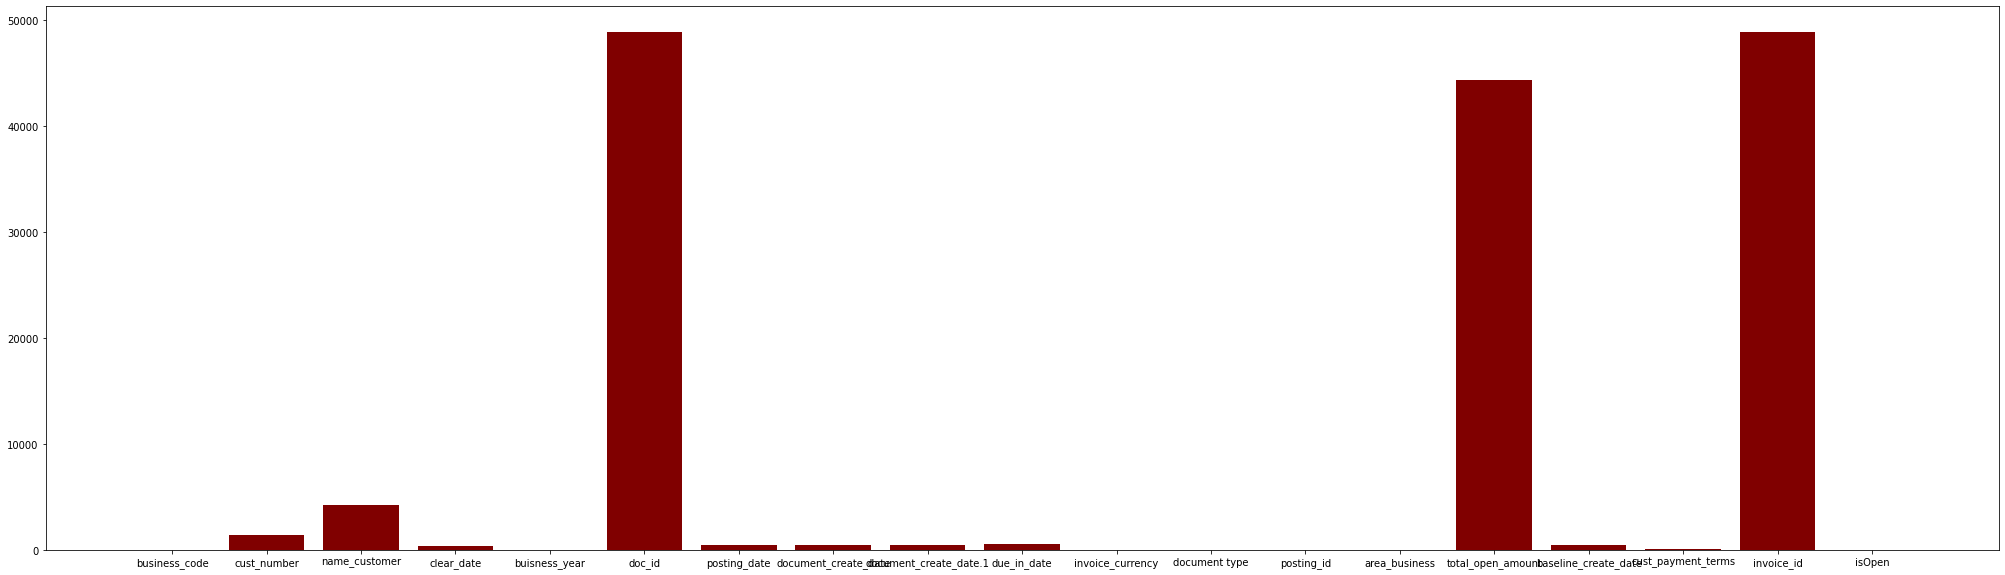

In [8]:

x_val = coun_t.index
y_val = coun_t.values.reshape(coun_t.shape[0])
plt.figure(figsize = (35,10))
plt.bar(x_val,y_val,color='maroon')
plt.show()

#### Mode - Most Frequently occuring Element

In [9]:
data[['business_code','buisness_year','invoice_currency','document type','cust_payment_terms','isOpen']].agg(pd.Series.mode)        

,business_code,buisness_year,invoice_currency,document type,cust_payment_terms,isOpen
0,U001,2019.0,USD,RV,NAA8,0


#### Median - Ordinal Variables ( 'invoice_id' ,buisness_year, isOpen )

In [10]:
data[['invoice_id','buisness_year','invoice_currency','isOpen']].agg(np.median).to_frame()         

,0
invoice_id,1.929964e+09
buisness_year,2.019000e+03
isOpen,0.000000e+00


#### Mean and Standard Deviation - interval level variables (total_open_amount)

In [11]:
data['total_open_amount'].agg(['mean','std']).to_frame()

,total_open_amount
mean,32337.021651
std,39205.975231


### DATA PRE-PROCESSING

#### REMOVING 'NULL' VALUES FROM THE DATAFRAME

In [12]:
null_vals = data.isnull().sum().to_frame(name = 'NULL_COUNTS')
null_vals = null_vals[null_vals['NULL_COUNTS']>0]
null_features = null_vals.index
null_vals

,NULL_COUNTS
clear_date,10000
area_business,50000
invoice_id,6


<AxesSubplot:title={'center':'NULL VALUES IN DATA'}, ylabel='NULL_COUNTS'>

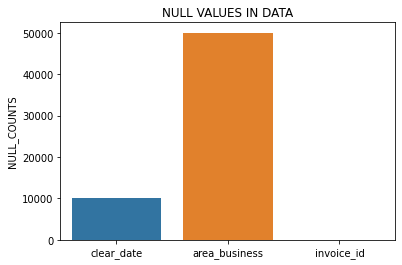

In [13]:
plt.title("NULL VALUES IN DATA")
seaborn.barplot(x=null_features,y=null_vals['NULL_COUNTS'])

In [14]:
# Analysis: "area_business" has all NaN values --> hence we drop that first
data=data.drop(columns=['area_business'])
data.shape

(50000, 18)

In [15]:
test_dataset = data[data['clear_date'].isnull() == True]
data = data.dropna()

In [16]:
test_dataset.shape

(10000, 18)

In [17]:
data.isnull().sum()  # All the rows with NULL values are dropped

business_code             0
cust_number               0
name_customer             0
clear_date                0
buisness_year             0
doc_id                    0
posting_date              0
document_create_date      0
document_create_date.1    0
due_in_date               0
invoice_currency          0
document type             0
posting_id                0
total_open_amount         0
baseline_create_date      0
cust_payment_terms        0
invoice_id                0
isOpen                    0
dtype: int64

#### REMOVING DUPLICATE VALUES FROM DATAFRAME 

In [18]:
print("Percentage of data lost due to dropping the NULL values in the dataframe : ",((50000-data.shape[0])/50000)*100 ,"%")  

Percentage of data lost due to dropping the NULL values in the dataframe :  20.012 %


In [19]:
#Dealing with the duplicates in the dataframe
data.duplicated().sum() # No Duplicate Values

842

In [20]:
test_dataset.duplicated().sum()

319

In [21]:
#looking for duplicated columns
data_trans = data.T
data_trans.duplicated()

business_code             False
cust_number               False
name_customer             False
clear_date                False
buisness_year             False
doc_id                    False
posting_date              False
document_create_date      False
document_create_date.1    False
due_in_date               False
invoice_currency          False
document type             False
posting_id                False
total_open_amount         False
baseline_create_date      False
cust_payment_terms        False
invoice_id                 True
isOpen                    False
dtype: bool

In [22]:
#looking for duplicated columns
test_dataset_trans = test_dataset.T
test_dataset_trans.duplicated()

business_code             False
cust_number               False
name_customer             False
clear_date                False
buisness_year             False
doc_id                    False
posting_date              False
document_create_date      False
document_create_date.1    False
due_in_date               False
invoice_currency          False
document type             False
posting_id                False
total_open_amount         False
baseline_create_date      False
cust_payment_terms        False
invoice_id                 True
isOpen                     True
dtype: bool

In [23]:
(data['doc_id'] != data['invoice_id']).sum() # Hence column 'doc_id' and 'invoice_id' are identical

0

In [24]:
# We are hence dropping the 'doc_id' column and some other unnecessary columns 
data = data.drop(columns=['doc_id'])  

In [25]:
test_dataset = test_dataset.drop(columns=['doc_id'])

In [26]:
gc.collect()
data.shape

(39994, 17)

In [27]:
test_dataset.shape

(10000, 17)

### Removing the column unique to each row : 'invoice_id'

In [28]:
data = data.drop(columns = 'invoice_id')
test_dataset = test_dataset.drop(columns = 'invoice_id')

### Removing the insignificant Columns

In [29]:
data1 = data.copy()
test_dataset1 = test_dataset.copy()

In [30]:
data.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'isOpen'],
      dtype='object')

In [31]:
data = data.drop(columns = ['name_customer', 'posting_date','document_create_date'])


In [32]:
test_dataset = test_dataset.drop(columns =  ['name_customer', 'posting_date','document_create_date'])

In [33]:
list(data.columns)

['business_code',
 'cust_number',
 'clear_date',
 'buisness_year',
 'document_create_date.1',
 'due_in_date',
 'invoice_currency',
 'document type',
 'posting_id',
 'total_open_amount',
 'baseline_create_date',
 'cust_payment_terms',
 'isOpen']

### FILTERING OUT THE CONSTANT FEATURES

In [34]:
const_feature = []
uniq_val_count = []
unique_cols = dict()
for col in list(data.columns):
    uniq_val_count.append(data[col].nunique())
    if(data[col].nunique()==1):
        const_feature.append(col)
    
print('\n\n\nConstant Features are   :',const_feature)
print('\n\nALL FEATURES WITH UNIQUE VALUES : \n')
pd.DataFrame({'COLUMN NAMES':list(data.columns) ,'UNIQUE VALUES COUNT':uniq_val_count})


# Removing the constant feature
data=data.drop(columns=const_feature)

# Removing the constant feature
test_dataset=test_dataset.drop(columns=const_feature)




Constant Features are   : ['document type', 'posting_id', 'isOpen']


ALL FEATURES WITH UNIQUE VALUES : 



In [35]:
list(data.columns)

['business_code',
 'cust_number',
 'clear_date',
 'buisness_year',
 'document_create_date.1',
 'due_in_date',
 'invoice_currency',
 'total_open_amount',
 'baseline_create_date',
 'cust_payment_terms']

### Label Encoding across categorical columns : [ 'business_code' ,'cust_number'  , 'cust_payment_terms']

In [36]:
data['business_code'].unique()

array(['U001', 'CA02', 'U013', 'U002', 'U007', 'U005'], dtype=object)

In [37]:
data['cust_number'].unique()

array(['0200769623', '0200980828', '0200792734', ..., '200274078',
       '0100052167', '0200541916'], dtype=object)

In [38]:
data['cust_payment_terms'].unique()

array(['NAH4', 'NAD1', 'NAA8', 'CA10', 'NAC6', 'NAAX', 'NAVE', 'NAG2',
       'NABG', 'NAM2', 'NA10', 'NAU5', 'NAD5', 'NAM4', 'NAWP', 'NAGD',
       'NAVR', 'CA30', 'NAM1', 'NAAW', 'NAVF', 'NAD4', 'NAUZ', 'NA3F',
       'NAX2', 'NAVQ', 'NATM', 'NA32', 'NAWM', 'NACB', 'NA38', 'NAWN',
       'NA84', 'C106', 'NAWU', 'NAB1', 'NA3B', 'NA9X', 'NAVD', 'CAB1',
       'NAVM', 'NA25', 'NAUP', 'NAM3', 'CAX2', 'NATV', 'NAVL', 'NATZ',
       'BR56', 'NA31', 'NATW', 'B052', 'NAV2', 'NATX', 'NAUY', 'NA8Q',
       'NATJ', 'BR12', 'NATU', '90M7', 'NAV9', 'NATK', 'CA60', 'NATL',
       'NAUW', 'NAVC', 'NABD', 'NATH', 'MC15', 'NAD8'], dtype=object)

In [39]:
data['buisness_year'].unique()

array([2020., 2019.])

In [40]:
### Assign 0 for unknown classes

class LabelEncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, data_list):
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self

    def transform(self, data_list):
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)
    
    

In [41]:
list_cust_details = ['buisness_year','cust_number','business_code','cust_payment_terms']

label_enc_list = dict()
for col in range(len(list_cust_details)):
    label_encoder = LabelEncoderExt()
    label_encoder.fit(data[list_cust_details[col]])
    data[list_cust_details[col]] = label_encoder.transform(data[list_cust_details[col]])
    label_enc_list[list_cust_details[col]]=label_encoder


In [42]:
test_dataset.columns

Index(['business_code', 'cust_number', 'clear_date', 'buisness_year',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms'],
      dtype='object')

In [43]:
for col in range(len(list_cust_details)):
    test_dataset[list_cust_details[col]] = label_enc_list[list_cust_details[col]].transform(test_dataset[list_cust_details[col]])

In [44]:
for col in list_cust_details:
    print(col,"   :     \n",data[col].unique(),"   \n     \n")

buisness_year    :     
 [2]    
     

cust_number    :     
 [ 849 1003  914 ... 1125  272  630]    
     

business_code    :     
 [1 0 5 2 4 3]    
     

cust_payment_terms    :     
 [35 29 21  5 27 23 59 33 26 37 11 50 31 39 67 34 64  6 36 22 60 30 54 17
 69 63 44 14 65 28 15 66 18  4 68 24 16 20 58  8 62 12 51 38  9 46 61 49
  3 13 47  1 55 48 53 19 41  2 45  0 56 42  7 43 52 57 25 40 10 32]    
     



#### DATE-TIME CONNVERSION

In [45]:
data

,business_code,cust_number,clear_date,buisness_year,document_create_date.1,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,1,849,2020-02-11 00:00:00,2,20200126,20200210.0,USD,54273.28,20200126.0,35
1,1,1003,2019-08-08 00:00:00,2,20190722,20190811.0,USD,79656.60,20190722.0,29
2,1,914,2019-12-30 00:00:00,2,20190914,20190929.0,USD,2253.86,20190914.0,21
4,1,849,2019-11-25 00:00:00,2,20191113,20191128.0,USD,33133.29,20191113.0,35
5,0,411,2019-12-04 00:00:00,2,20190920,20191004.0,CAD,22225.84,20190924.0,5
...,...,...,...,...,...,...,...,...,...,...
49994,1,832,2019-07-25 00:00:00,2,20190710,20190725.0,USD,84780.40,20190710.0,27
49996,1,849,2019-09-03 00:00:00,2,20190815,20190830.0,USD,6766.54,20190815.0,35
49997,1,854,2020-03-05 00:00:00,2,20200219,20200305.0,USD,6120.86,20200219.0,21
49998,1,750,2019-12-12 00:00:00,2,20191127,20191212.0,USD,63.48,20191127.0,21


In [46]:
def str_to_date(time_s,st):
    st=''
    for i in range(len(time_s)+3):
        if(i<4):
            st+=time_s[i]
        if(i==4):
            st+='-'
        if(i==5 or i==6):
            st+= time_s[i-1]
        if(i==7):
            st+='-'
        if(i==8 or i==9):
            st+=time_s[i-2]
    return st  #### REMOVING 'NULL' VALUES FROM THE DATAFRAME

In [47]:
dt_lis = ['baseline_create_date','clear_date','due_in_date','document_create_date.1']

st = ''
data['baseline_create_date'] = pd.Series(data['baseline_create_date']).map(lambda x: str_to_date(str(int(x)),st))
data['due_in_date'] = pd.Series(data['due_in_date']).map(lambda x: str_to_date(str(int(x)),st))
data['document_create_date.1'] = pd.Series(data['document_create_date.1']).map(lambda x: str_to_date(str(int(x)),st))

In [48]:
st = ''
test_dataset['baseline_create_date'] = pd.Series(test_dataset['baseline_create_date']).map(lambda x: str_to_date(str(int(x)),st))
test_dataset['due_in_date'] = pd.Series(test_dataset['due_in_date']).map(lambda x: str_to_date(str(int(x)),st))
test_dataset['document_create_date.1'] = pd.Series(test_dataset['document_create_date.1']).map(lambda x: str_to_date(str(int(x)),st))

In [49]:
dt_lis = ['baseline_create_date','clear_date','due_in_date','document_create_date.1']

for col in dt_lis:
    data[col] = pd.to_datetime(data[col],format='%Y-%m-%d')
data.shape

(39994, 10)

In [50]:
for col in dt_lis:
    test_dataset[col] = pd.to_datetime(test_dataset[col],format='%Y-%m-%d')
test_dataset.shape

(10000, 10)

### FILTERING OUT THE QUASI-CONSTANT FEATURES

In [51]:
data.columns

Index(['business_code', 'cust_number', 'clear_date', 'buisness_year',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms'],
      dtype='object')

In [52]:
selection = VarianceThreshold(threshold=0.01) # of more that 99% values are same -- we remove the column

cols = list(set(data.columns) - (set(dt_lis) | set(['invoice_currency'])))

selection.fit(data[cols])

print("No. of Features that are Quasi-Constant : ",(len(cols) - sum(selection.get_support())))

quasi_ = list(selection.get_support())

for i in range(len(quasi_)):
    if quasi_[i] == False:
        print("The Quasi-Constant Feature in train data is  :",cols[i])
        data=data.drop(columns=[cols[i]])

for i in range(len(quasi_)):
    if quasi_[i] == False:
        print("The Quasi-Constant Feature in test data is  :",cols[i])
        test_dataset=test_dataset.drop(columns=[cols[i]])


No. of Features that are Quasi-Constant :  1
The Quasi-Constant Feature in train data is  : buisness_year
The Quasi-Constant Feature in test data is  : buisness_year


### DROPPING THE COLUMNS WHERE THE DOCUMENT FOR INVOICES ARE CREATED BEFORE THE BASELINE CREATE DATE

In [53]:
temp = pd.Series(data['document_create_date.1'] - data['baseline_create_date']).dt.days

In [54]:
rows_to_drop = temp.value_counts().to_frame(name = 'count')

In [55]:
# No. of rows to drop satisfying the condition
rows_to_drop[(rows_to_drop.index <0)].sum()

count    2669
dtype: int64

In [56]:
data = data[((temp==0) | (temp>0))].reset_index(drop=True)

In [57]:
data.shape

(37325, 9)

In [58]:
data = data.drop(columns = ['document_create_date.1'])

In [59]:
test_dataset = test_dataset.drop(columns = ['document_create_date.1'])

### FEATURE ENGINEERING / FEATURE GENERATION

In [60]:
dates_list = ['due_in_date','baseline_create_date'] #payment date is excluded  

In [61]:
data.columns

Index(['business_code', 'cust_number', 'clear_date', 'due_in_date',
       'invoice_currency', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms'],
      dtype='object')

In [62]:
data['payment_term']=pd.Series(data['clear_date'] - data['baseline_create_date']).dt.days
data['due_term']=pd.Series(data['due_in_date'] - data['baseline_create_date']).dt.days
data['delay'] = data['payment_term'] - data['due_term']
test_dataset['due_term']=pd.Series(test_dataset['due_in_date'] - test_dataset['baseline_create_date']).dt.days

### BUCKET COMPUTATION - > BASED ON DUE TERM, PAYMENT TERM , AND DELAY

In [63]:
def bucketization(x):
    if x<0:
        return('(< 0) Days')
    if x in range(0,16):
        return('(0-15) Days')
    elif x in range(16,31):
        return('(16-30) Days')
    elif x in range(31,45):
        return('(31-45) Days')
    elif x in range(45,60):
        return('(45-60) Days')
    else:
        return('(> 60) Days')

In [64]:
gc.collect()

data = data.reset_index(drop=True)

data['DELAY BUCKET(DAYS)']= pd.Series([bucketization(x=data['delay'][i])  for i in range(len(data))])
data['DUE TERM BUCKET(DAYS)']= pd.Series([bucketization(x=data['due_term'][i])  for i in range(len(data))])


bucket_mapper = {'(< 0) Days':0,'(0-15) Days':1,'(16-30) Days':2,'(31-45) Days':4,'(45-60) Days':5,'(> 60) Days':6}

data['delay_bucket_id'] = data['DELAY BUCKET(DAYS)'].map(bucket_mapper)
data['due_term_bucket_id'] = data['DUE TERM BUCKET(DAYS)'].map(bucket_mapper)

data.columns

Index(['business_code', 'cust_number', 'clear_date', 'due_in_date',
       'invoice_currency', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms', 'payment_term', 'due_term', 'delay',
       'DELAY BUCKET(DAYS)', 'DUE TERM BUCKET(DAYS)', 'delay_bucket_id',
       'due_term_bucket_id'],
      dtype='object')

In [65]:
test_dataset = test_dataset.reset_index(drop=True)
test_dataset['DUE TERM BUCKET(DAYS)']= pd.Series([bucketization(x=test_dataset['due_term'][i])  for i in range(len(test_dataset))])
test_dataset['due_term_bucket_id'] = test_dataset['DUE TERM BUCKET(DAYS)'].map(bucket_mapper)

In [66]:
test_dataset.columns

Index(['business_code', 'cust_number', 'clear_date', 'due_in_date',
       'invoice_currency', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms', 'due_term', 'DUE TERM BUCKET(DAYS)',
       'due_term_bucket_id'],
      dtype='object')

### Grouping on the basis of features: 'cust_number'and generating new features

In [67]:
test_dataset=test_dataset.drop(columns=['clear_date'])

In [68]:
for col1 in ['baseline_create_date','due_in_date']:
    data['{}.day'.format(col1)]=data[col1].dt.day
    data['{}.year'.format(col1)]=data[col1].dt.year
    data['{}.month'.format(col1)]=data[col1].dt.month
    test_dataset['{}.day'.format(col1)]=test_dataset[col1].dt.day
    test_dataset['{}.year'.format(col1)]=test_dataset[col1].dt.year
    test_dataset['{}.month'.format(col1)]=test_dataset[col1].dt.month
    test_dataset['{}.day_of_week'.format(col1)]=test_dataset[col1].dt.dayofweek

In [69]:
df1 = data.groupby('cust_number').sum()
df = df1.rename(columns = {'total_open_amount':'Sum_base_amount'})['Sum_base_amount']
df2 = df1.rename(columns = {'due_term':'Sum_due_term'})['Sum_due_term']

data = pd.merge(data,df,on = 'cust_number' )
data = pd.merge(data,df2,on = 'cust_number' )

df = data.groupby('cust_number').mean()
df = df.rename(columns = {'total_open_amount':'mean_base_amount','due_term':'mean_due_term'})
data = pd.merge(data,df['mean_base_amount'],on = 'cust_number' )
data = pd.merge(data,df['mean_due_term'],on = 'cust_number' )

data['amount/mean_amount'] = data['total_open_amount']/data['mean_base_amount']
data['amount-/mean_amount'] = (data['total_open_amount']-data['mean_base_amount'])/data['mean_base_amount']
data['due_term/amount'] = data['due_term']/data['total_open_amount']
data['mean_due_term/amount'] = data['mean_due_term']/data['total_open_amount']
data['mean_due_term/Sum_base_amount'] = data['mean_due_term']/data['Sum_base_amount']

In [70]:
df1 = test_dataset.groupby('cust_number').sum()
df = df1.rename(columns = {'total_open_amount':'Sum_base_amount'})['Sum_base_amount']
df2 = df1.rename(columns = {'due_term':'Sum_due_term'})['Sum_due_term']
test_dataset = pd.merge(test_dataset,df,on = 'cust_number' )
test_dataset = pd.merge(test_dataset,df2,on = 'cust_number' )

df = test_dataset.groupby('cust_number').mean()
df = df.rename(columns = {'total_open_amount':'mean_base_amount','due_term':'mean_due_term'})
test_dataset = pd.merge(test_dataset,df['mean_base_amount'],on = 'cust_number' )
test_dataset = pd.merge(test_dataset,df['mean_due_term'],on = 'cust_number' )

test_dataset['amount/mean_amount'] = test_dataset['total_open_amount']/test_dataset['mean_base_amount']
test_dataset['amount-/mean_amount'] = (test_dataset['total_open_amount']- test_dataset['mean_base_amount'])/test_dataset['mean_base_amount']
test_dataset['due_term/amount'] = test_dataset['due_term']/test_dataset['total_open_amount']
test_dataset['mean_due_term/amount'] = test_dataset['mean_due_term']/test_dataset['total_open_amount']
test_dataset['mean_due_term/Sum_base_amount'] = test_dataset['mean_due_term']/test_dataset['Sum_base_amount']

In [71]:
df = dict(zip(list(data['cust_number'].value_counts().index),list(data['cust_number'].value_counts())))

data['cust_count'] = data['cust_number'].map(df)
data['cust_count/mean_amount'] = data['cust_count']/data['mean_base_amount']

test_dataset['cust_count'] = test_dataset['cust_number'].map(df)
test_dataset['cust_count/mean_amount'] = test_dataset['cust_number']/test_dataset['mean_base_amount']

### Sorting the dataframe according to the'baseline_create_date'

In [72]:
data = data.sort_values(['baseline_create_date']).reset_index(drop=True)
data['cust_count*due_term/amount'] =(data['cust_count']*data['due_term'])/data['total_open_amount']

In [73]:
test_dataset = test_dataset.sort_values(['baseline_create_date']).reset_index(drop=True)
test_dataset['cust_count*due_term/amount'] =(test_dataset['cust_count']*test_dataset['due_term'])/test_dataset['total_open_amount']

In [74]:
data.isnull().sum()

business_code                    0
cust_number                      0
clear_date                       0
due_in_date                      0
invoice_currency                 0
total_open_amount                0
baseline_create_date             0
cust_payment_terms               0
payment_term                     0
due_term                         0
delay                            0
DELAY BUCKET(DAYS)               0
DUE TERM BUCKET(DAYS)            0
delay_bucket_id                  0
due_term_bucket_id               0
baseline_create_date.day         0
baseline_create_date.year        0
baseline_create_date.month       0
due_in_date.day                  0
due_in_date.year                 0
due_in_date.month                0
Sum_base_amount                  0
Sum_due_term                     0
mean_base_amount                 0
mean_due_term                    0
amount/mean_amount               0
amount-/mean_amount              0
due_term/amount                  0
mean_due_term/amount

 ### MANIPULATING THE 'AMOUNT COLUMN - CONVERTING TO USD
##### CAD -> CANADIAN DOLLAR 
##### USD -> US DOLLAR 

##### Convertion:

##### 1 CAD = 0.79 USD

In [75]:
x = data[data['invoice_currency']=='CAD']['total_open_amount'].map(lambda x: x*0.79)    

for i in x.index:
    data['total_open_amount'][i] = 0.79*x[i]


data = data.drop(columns=['invoice_currency'])

x = test_dataset[test_dataset['invoice_currency']=='CAD']['total_open_amount'].map(lambda x: x*0.79)    

for i in x.index:
    test_dataset['total_open_amount'][i] = 0.79*x[i]
test_dataset = test_dataset.drop(columns=['invoice_currency'])  

In [76]:
test_dataset = test_dataset.sort_values(['baseline_create_date']).reset_index(drop=True)
test_dataset

,business_code,cust_number,due_in_date,total_open_amount,baseline_create_date,cust_payment_terms,due_term,DUE TERM BUCKET(DAYS),due_term_bucket_id,baseline_create_date.day,...,mean_base_amount,mean_due_term,amount/mean_amount,amount-/mean_amount,due_term/amount,mean_due_term/amount,mean_due_term/Sum_base_amount,cust_count,cust_count/mean_amount,cust_count*due_term/amount
0,1,845,2020-03-13,73671.8400,2020-02-27,21,15,(0-15) Days,1,27,...,55067.007500,15.000000,1.337858,0.337858,0.000204,0.000204,6.809885e-05,7.0,0.015345,0.001425
1,1,971,2020-03-13,40291.5000,2020-02-27,21,15,(0-15) Days,1,27,...,25205.940000,15.000000,1.598492,0.598492,0.000372,0.000372,2.975489e-04,35.0,0.038523,0.013030
2,1,875,2020-03-13,1133.8200,2020-02-27,21,15,(0-15) Days,1,27,...,59686.804286,16.098901,0.018996,-0.981004,0.013230,0.014199,2.963988e-06,388.0,0.014660,5.133090
3,1,1342,2020-02-27,14360.9600,2020-02-27,69,0,(0-15) Days,1,27,...,16420.178657,0.000000,0.874592,-0.125408,0.000000,0.000000,0.000000e+00,540.0,0.081729,0.000000
4,1,849,2020-03-13,7536.5000,2020-02-27,35,15,(0-15) Days,1,27,...,22006.897115,15.098386,0.342461,-0.657539,0.001990,0.002003,2.700020e-07,8932.0,0.038579,17.777483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,591,2020-05-15,12182.4600,2020-05-15,70,0,(0-15) Days,1,15,...,4499.876667,0.000000,2.707288,1.707288,0.000000,0.000000,0.000000e+00,NaN,0.131337,NaN
9996,1,826,2020-06-01,22835.5000,2020-05-17,35,15,(0-15) Days,1,17,...,30171.853687,17.875000,0.756848,-0.243152,0.000657,0.000783,1.851374e-06,1073.0,0.027377,0.704824
9997,1,976,2020-06-02,1232.0000,2020-05-18,21,15,(0-15) Days,1,18,...,18309.810741,15.000000,0.067286,-0.932714,0.012175,0.012175,3.034196e-05,77.0,0.053305,0.937500
9998,0,99,2020-05-19,4390.5435,2020-05-19,8,0,(0-15) Days,1,19,...,10120.320000,0.000000,0.695136,-0.304864,0.000000,0.000000,0.000000e+00,6.0,0.009782,0.000000


In [77]:
cols_drop1 = set(data.columns) - set(test_dataset.columns)
cols_drop1

{'DELAY BUCKET(DAYS)',
 'clear_date',
 'delay',
 'delay_bucket_id',
 'payment_term'}

In [78]:
data.corr()['payment_term']

business_code                    0.237232
cust_number                      0.084024
total_open_amount               -0.056671
cust_payment_terms               0.296938
payment_term                     1.000000
due_term                         0.628176
delay                            0.613835
delay_bucket_id                  0.593911
due_term_bucket_id               0.652960
baseline_create_date.day         0.007231
baseline_create_date.year        0.000203
baseline_create_date.month      -0.054910
due_in_date.day                 -0.020083
due_in_date.year                -0.008333
due_in_date.month                0.020254
Sum_base_amount                 -0.240961
Sum_due_term                    -0.242956
mean_base_amount                 0.039502
mean_due_term                    0.412509
amount/mean_amount              -0.061311
amount-/mean_amount             -0.061311
due_term/amount                  0.071161
mean_due_term/amount             0.017095
mean_due_term/Sum_base_amount    0

In [79]:
# Dropping the date columns

#data = data.drop(columns = ['clear_date', 'due_in_date','baseline_create_date'])
#test_dataset = test_dataset.drop(columns = ['due_in_date','baseline_create_date'])

#### LOG TRANSFORMATION OF 'total_open_amount'

In [80]:
data['total_open_amount'] = np.log(data['total_open_amount'])

In [81]:
test_dataset['total_open_amount'] = np.log(test_dataset['total_open_amount'])

In [82]:
# Looking For the values of categorical features which are diffrent from train data
list_cust_details = ['cust_number','business_code','cust_payment_terms']

for col in list_cust_details:
    coun = 0
    for i in range(len(test_dataset)):
        if test_dataset[col][i] in set(test_dataset[col])-set(data[col]):
            coun+=1
    print("\n\n\nColumn Name:    ",col,"\nTotal Unique Values in train-set:     ",data[col].nunique(),"\nNew Valuess introduced in Test:     ",len(set(test_dataset[col].unique()) - set(data[col].unique())),"\nValues are:",set(test_dataset[col])-set(data[col]),"\nCount :",coun)




Column Name:     cust_number 
Total Unique Values in train-set:      1210 
New Valuess introduced in Test:      44 
Values are: {130, 386, 389, 1030, 393, 398, 403, 406, 151, 153, 409, 156, 412, 415, 417, 162, 35, 418, 419, 423, 424, 426, 431, 432, 49, 1076, 1081, 1343, 1091, 73, 591, 357, 360, 365, 366, 111, 367, 368, 370, 116, 374, 377, 382, 383} 
Count : 227



Column Name:     business_code 
Total Unique Values in train-set:      6 
New Valuess introduced in Test:      0 
Values are: set() 
Count : 0



Column Name:     cust_payment_terms 
Total Unique Values in train-set:      59 
New Valuess introduced in Test:      1 
Values are: {70} 
Count : 10


In [83]:
data.columns

Index(['business_code', 'cust_number', 'clear_date', 'due_in_date',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms',
       'payment_term', 'due_term', 'delay', 'DELAY BUCKET(DAYS)',
       'DUE TERM BUCKET(DAYS)', 'delay_bucket_id', 'due_term_bucket_id',
       'baseline_create_date.day', 'baseline_create_date.year',
       'baseline_create_date.month', 'due_in_date.day', 'due_in_date.year',
       'due_in_date.month', 'Sum_base_amount', 'Sum_due_term',
       'mean_base_amount', 'mean_due_term', 'amount/mean_amount',
       'amount-/mean_amount', 'due_term/amount', 'mean_due_term/amount',
       'mean_due_term/Sum_base_amount', 'cust_count', 'cust_count/mean_amount',
       'cust_count*due_term/amount'],
      dtype='object')

In [84]:
gc.collect()

78

### CORRELATION MATRIX

In [85]:
d_corr=data.corr()
d_corr

,business_code,cust_number,total_open_amount,cust_payment_terms,payment_term,due_term,delay,delay_bucket_id,due_term_bucket_id,baseline_create_date.day,...,mean_base_amount,mean_due_term,amount/mean_amount,amount-/mean_amount,due_term/amount,mean_due_term/amount,mean_due_term/Sum_base_amount,cust_count,cust_count/mean_amount,cust_count*due_term/amount
business_code,1.000000,-5.527031e-02,-0.007007,0.365415,0.237232,0.235305,0.058080,0.055508,0.240546,0.006141,...,-9.631196e-02,3.890165e-01,-6.152791e-05,-6.152791e-05,0.006337,0.007532,1.746282e-02,-5.797337e-02,-6.077153e-02,-0.009450
cust_number,-0.055270,1.000000e+00,0.024345,0.240020,0.084024,-0.052233,0.158126,0.132556,0.007670,0.016231,...,-5.673911e-02,-8.635484e-02,-3.010694e-16,-3.758124e-16,-0.030433,-0.023763,-2.172874e-02,1.190105e-01,8.996855e-02,0.009341
total_open_amount,-0.007007,2.434455e-02,1.000000,-0.125891,-0.058942,-0.080212,0.007636,-0.003883,-0.079795,0.035845,...,4.565555e-01,8.021723e-02,5.559185e-01,5.559185e-01,-0.296510,-0.256591,-4.577496e-02,-6.924167e-02,-2.400343e-01,-0.271241
cust_payment_terms,0.365415,2.400198e-01,-0.125891,1.000000,0.296938,0.250129,0.117742,0.079564,0.273595,-0.018805,...,-2.250261e-01,6.894742e-02,-2.438864e-02,-2.438864e-02,0.057909,0.019873,1.328560e-02,3.333034e-01,2.667953e-01,0.050181
payment_term,0.237232,8.402399e-02,-0.058942,0.296938,1.000000,0.628176,0.613835,0.593911,0.652960,0.007231,...,3.950231e-02,4.125091e-01,-6.131073e-02,-6.131073e-02,0.071161,0.017095,4.272056e-02,-2.427268e-01,-2.408787e-01,-0.002026
due_term,0.235305,-5.223348e-02,-0.080212,0.250129,0.628176,1.000000,-0.228640,-0.081577,0.935181,-0.004551,...,4.303762e-02,6.048703e-01,-7.963722e-02,-7.963722e-02,0.106322,0.030336,3.341509e-02,-1.485202e-01,-1.611380e-01,0.000670
delay,0.058080,1.581258e-01,0.007636,0.117742,0.613835,-0.228640,1.000000,0.825860,-0.131864,0.013665,...,5.758568e-03,-9.757840e-02,4.089152e-03,4.089152e-03,-0.018840,-0.009390,1.954825e-02,-1.530069e-01,-1.378926e-01,-0.003214
delay_bucket_id,0.055508,1.325555e-01,-0.003883,0.079564,0.593911,-0.081577,0.825860,1.000000,0.013102,0.014684,...,8.401939e-02,-4.518447e-02,-1.038106e-02,-1.038106e-02,0.007000,0.002536,2.278057e-02,-3.497499e-01,-2.994888e-01,-0.023596
due_term_bucket_id,0.240546,7.670147e-03,-0.079795,0.273595,0.652960,0.935181,-0.131864,0.013102,1.000000,-0.010609,...,-4.763692e-03,5.680026e-01,-6.601274e-02,-6.601274e-02,0.088712,0.024180,2.978975e-02,-2.009485e-01,-2.124361e-01,-0.011882
baseline_create_date.day,0.006141,1.623129e-02,0.035845,-0.018805,0.007231,-0.004551,0.013665,0.014684,-0.010609,1.000000,...,3.936357e-02,-2.536993e-03,5.055291e-03,5.055291e-03,-0.009758,-0.005721,6.095987e-03,2.274421e-02,1.818922e-02,0.000899


### COVARIANCE MATRIX

In [86]:
data.cov()

,business_code,cust_number,total_open_amount,cust_payment_terms,payment_term,due_term,delay,delay_bucket_id,due_term_bucket_id,baseline_create_date.day,...,mean_base_amount,mean_due_term,amount/mean_amount,amount-/mean_amount,due_term/amount,mean_due_term/amount,mean_due_term/Sum_base_amount,cust_count,cust_count/mean_amount,cust_count*due_term/amount
business_code,2.329100e-01,-6.132326e+00,-6.032647e-03,1.948159e+00,1.497679e+00,1.204621e+00,2.930579e-01,2.101365e-02,1.250635e-01,2.608810e-02,...,-9.672530e+02,1.204621e+00,-3.568004e-05,-3.568004e-05,0.000411,0.000493,7.846104e-05,-1.025499e+02,-5.071063e-03,-1.277531e+00
cust_number,-6.132326e+00,5.285406e+04,9.983934e+00,6.095792e+02,2.526933e+02,-1.273838e+02,3.800770e+02,2.390483e+01,1.899683e+00,3.284809e+01,...,-2.714485e+05,-1.273838e+02,-3.655134e-16,1.462053e-16,-0.941247,-0.740506,-4.650712e-02,1.002853e+05,3.576306e+00,6.015311e+02
total_open_amount,-6.032647e-03,9.983934e+00,3.182157e+00,-2.480842e+00,-1.375418e+00,-1.517835e+00,1.424165e-01,-5.432923e-03,-1.533462e-01,5.628721e-01,...,1.694806e+04,9.181565e-01,1.191601e+00,1.191601e+00,-0.071156,-0.062043,-7.602113e-04,-4.527317e+02,-7.403530e-02,-1.355350e+02
cust_payment_terms,1.948159e+00,6.095792e+02,-2.480842e+00,1.220359e+02,4.291020e+01,2.931121e+01,1.359899e+01,6.894603e-01,3.256038e+00,-1.828636e+00,...,-5.172999e+04,4.887088e+00,-3.237357e-01,-3.237357e-01,0.086060,0.029757,1.366377e-03,1.349572e+04,5.095969e-01,1.552824e+02
payment_term,1.497679e+00,2.526933e+02,-1.375418e+00,4.291020e+01,1.711206e+02,8.716825e+01,8.395235e+01,6.094263e+00,9.201867e+00,8.326780e-01,...,1.075324e+04,3.462366e+01,-9.637108e-01,-9.637108e-01,0.125229,0.030311,5.202759e-03,-1.163808e+04,-5.448216e-01,-7.422935e+00
due_term,1.204621e+00,-1.273838e+02,-1.517835e+00,2.931121e+01,8.716825e+01,1.125258e+02,-2.535755e+01,-6.787994e-01,1.068710e+01,-4.249545e-01,...,9.500359e+03,4.116960e+01,-1.015082e+00,-1.015082e+00,0.151727,0.043618,3.300003e-03,-5.774630e+03,-2.955485e-01,1.990576e+00
delay,2.930579e-01,3.800770e+02,1.424165e-01,1.359899e+01,8.395235e+01,-2.535755e+01,1.093099e+02,6.773062e+00,-1.485237e+00,1.257633e+00,...,1.252882e+03,-6.545936e+00,5.137148e-02,5.137148e-02,-0.026498,-0.013308,1.902756e-03,-5.863451e+03,-2.492731e-01,-9.413511e+00
delay_bucket_id,2.101365e-02,2.390483e+01,-5.432923e-03,6.894603e-01,6.094263e+00,-6.787994e-01,6.773062e+00,6.153149e-01,1.107171e-02,1.013970e-01,...,1.371494e+03,-2.274187e-01,-9.784743e-03,-9.784743e-03,0.000739,0.000270,1.663638e-04,-1.005585e+03,-4.061946e-02,-5.184590e+00
due_term_bucket_id,1.250635e-01,1.899683e+00,-1.533462e-01,3.256038e+00,9.201867e+00,1.068710e+01,-1.485237e+00,1.107171e-02,1.160584e+00,-1.006050e-01,...,-1.067942e+02,3.926241e+00,-8.545259e-02,-8.545259e-02,0.012857,0.003531,2.987795e-04,-7.934797e+02,-3.957049e-02,-3.585606e+00
baseline_create_date.day,2.608810e-02,3.284809e+01,5.628721e-01,-1.828636e+00,8.326780e-01,-4.249545e-01,1.257633e+00,1.013970e-01,-1.006050e-01,7.748826e+01,...,7.210713e+03,-1.432932e-01,5.347160e-02,5.347160e-02,-0.011556,-0.006826,4.995829e-04,7.338399e+02,2.768451e-02,2.217934e+00


### PIE PLOT

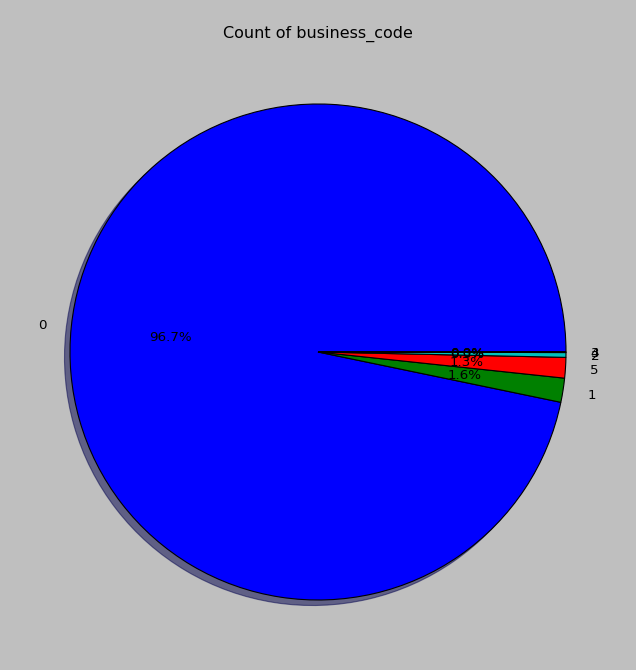

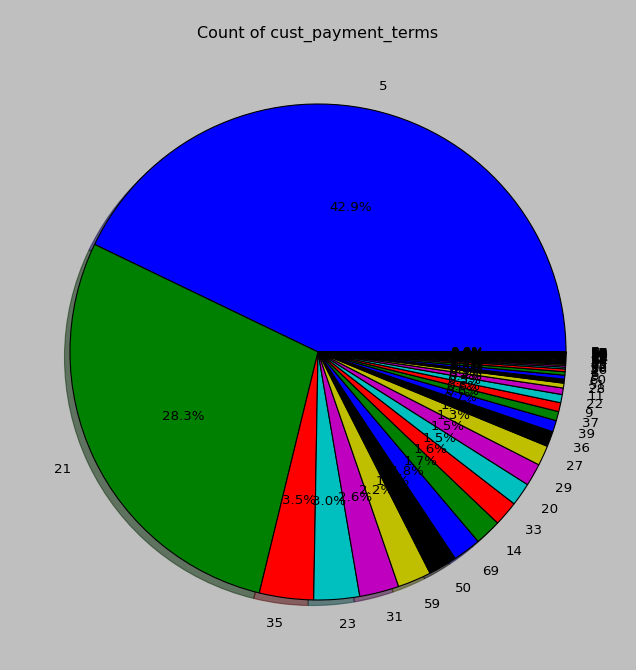

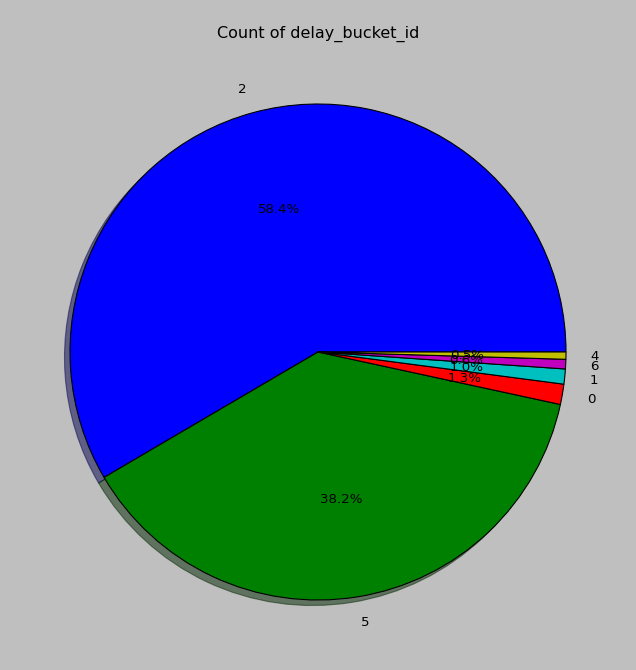

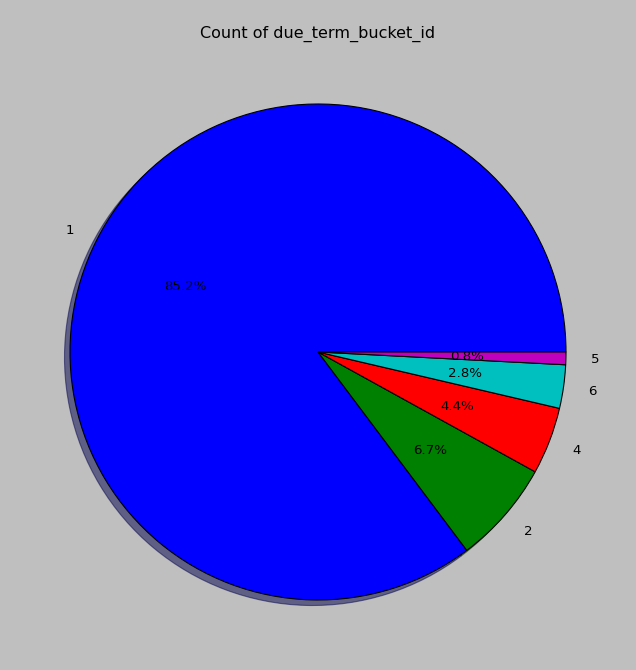

In [87]:
for col in ['business_code','cust_payment_terms', 'delay_bucket_id','due_term_bucket_id']:
    plt.style.use('classic')
    fig,ax = plt.subplots(figsize=(10,10))
    plt.pie(data[col].value_counts(),labels=data[col].unique(),shadow=True,autopct='%1.1f%%')
    plt.title('\nCount of {}'.format(col))
    plt.show()

 #### BAR PLOT

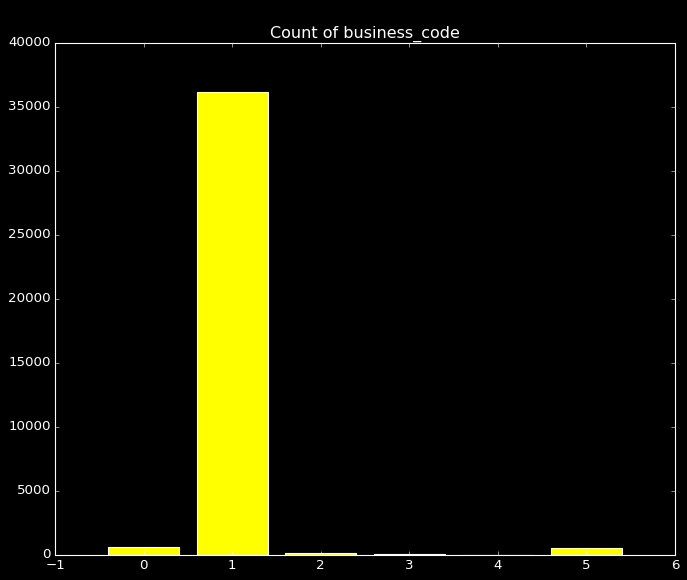

<Figure size 1600x1600 with 0 Axes>

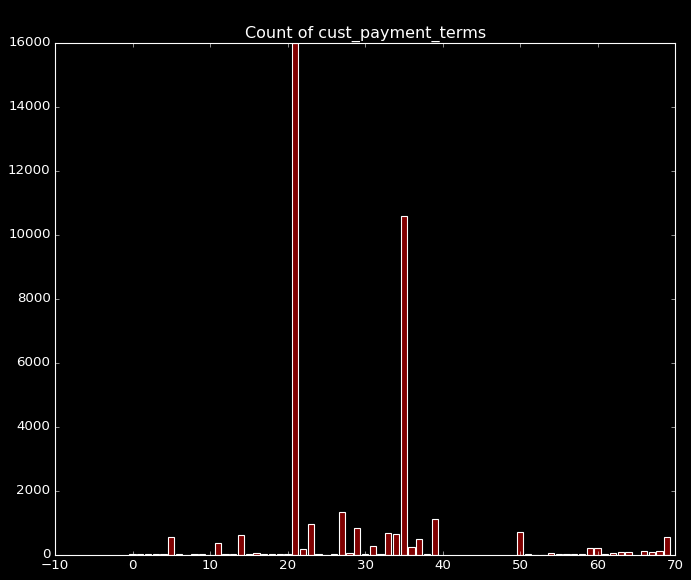

<Figure size 1600x1600 with 0 Axes>

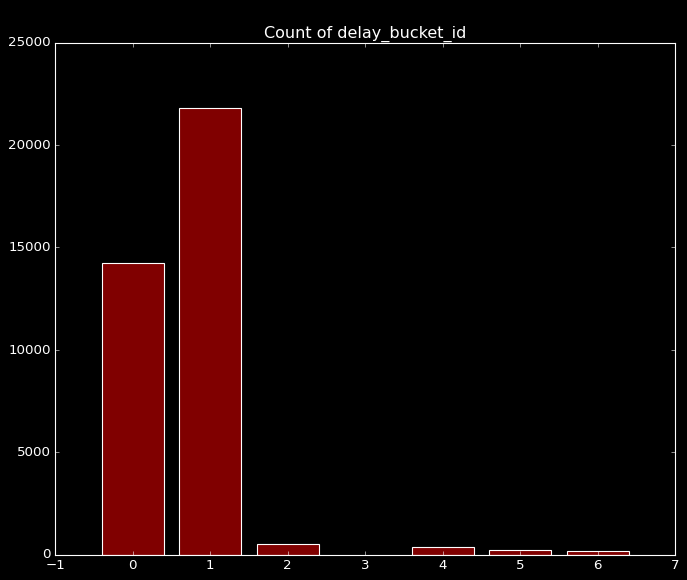

<Figure size 1600x1600 with 0 Axes>

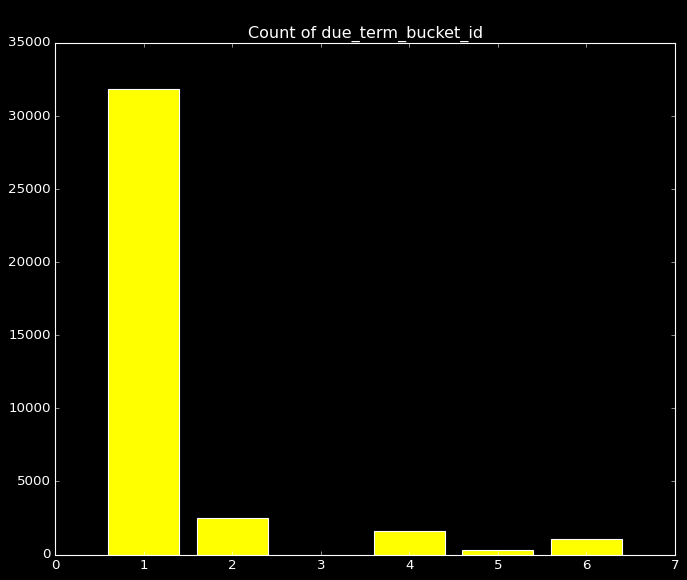

<Figure size 1600x1600 with 0 Axes>

In [88]:
features = ['business_code','cust_payment_terms', 'delay_bucket_id','due_term_bucket_id']

for col in features:
    plt.style.use('dark_background')
    fig,ax = plt.subplots(figsize=(10,8))
    plt.bar(list(data[col].value_counts().index),list(data[col].value_counts()),color = random.sample(['maroon','yellow'],1))            
    plt.title('\nCount of {}'.format(col))
    plt.figure(figsize=(20,20))
    plt.show()

#### BOX PLOT 

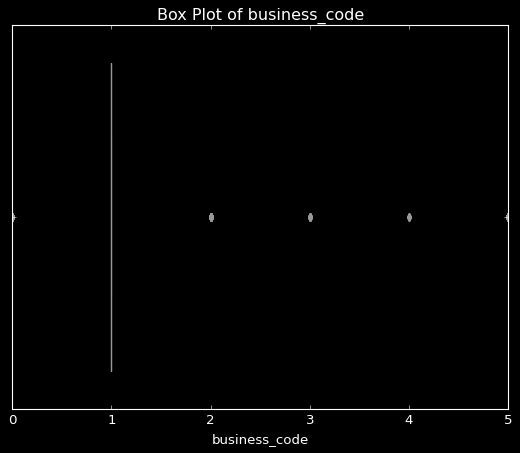

<Figure size 1600x1600 with 0 Axes>

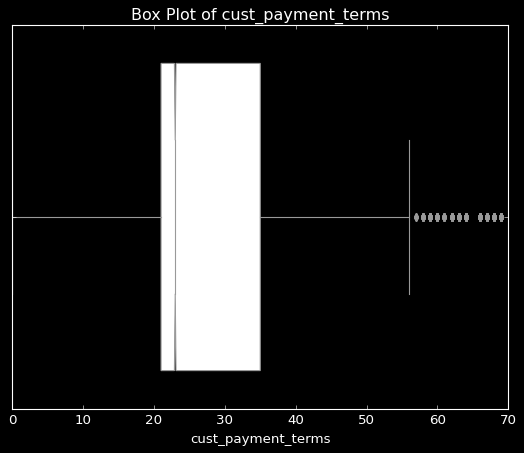

<Figure size 1600x1600 with 0 Axes>

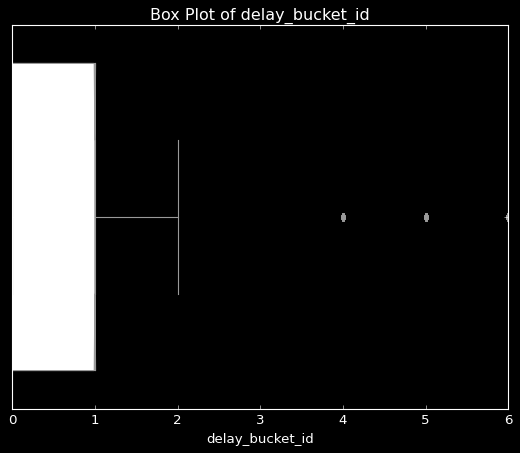

<Figure size 1600x1600 with 0 Axes>

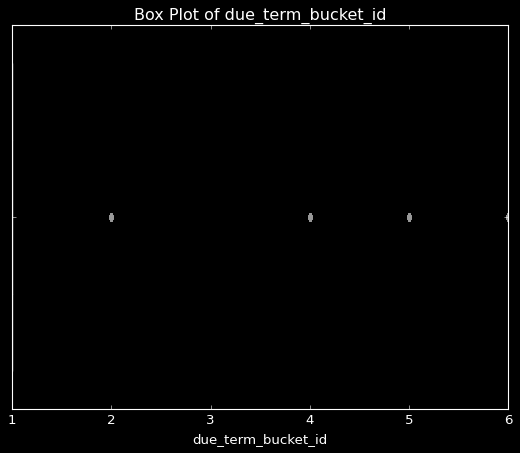

<Figure size 1600x1600 with 0 Axes>

In [89]:
features = ['business_code','cust_payment_terms', 'delay_bucket_id','due_term_bucket_id']

for col in features:
    plt.style.use('dark_background')
    seaborn.boxplot(data[col],color='white',notch=True)
    plt.title('Box Plot of {}'.format(col))
    plt.figure(figsize=(20,20))
    plt.show()

#### Scatter Plot

In [90]:
data.columns

Index(['business_code', 'cust_number', 'clear_date', 'due_in_date',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms',
       'payment_term', 'due_term', 'delay', 'DELAY BUCKET(DAYS)',
       'DUE TERM BUCKET(DAYS)', 'delay_bucket_id', 'due_term_bucket_id',
       'baseline_create_date.day', 'baseline_create_date.year',
       'baseline_create_date.month', 'due_in_date.day', 'due_in_date.year',
       'due_in_date.month', 'Sum_base_amount', 'Sum_due_term',
       'mean_base_amount', 'mean_due_term', 'amount/mean_amount',
       'amount-/mean_amount', 'due_term/amount', 'mean_due_term/amount',
       'mean_due_term/Sum_base_amount', 'cust_count', 'cust_count/mean_amount',
       'cust_count*due_term/amount'],
      dtype='object')

#### Scatter Plot

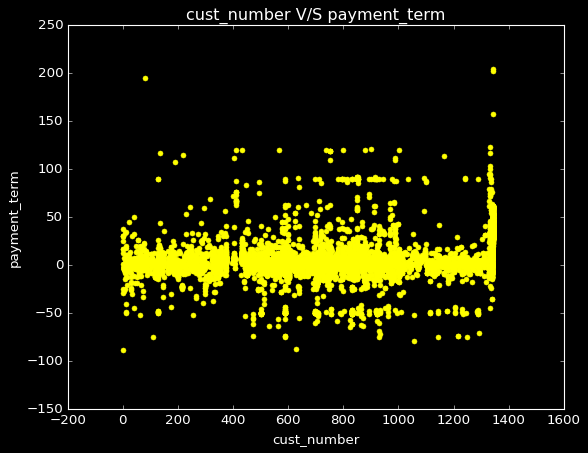

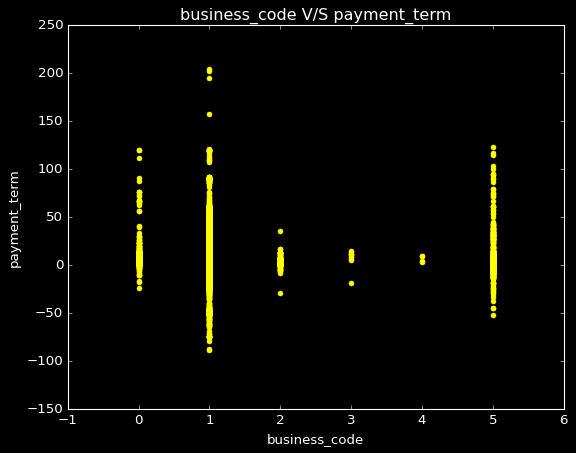

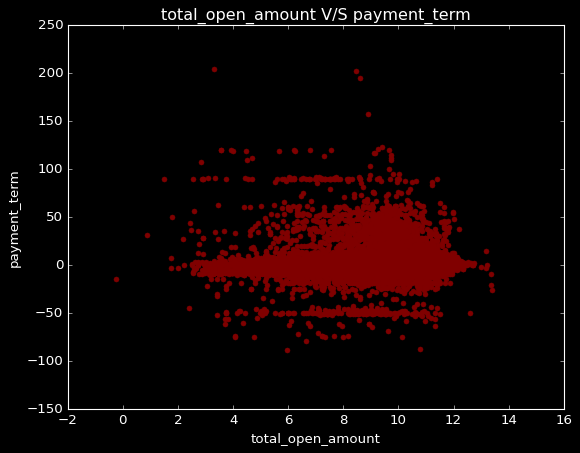

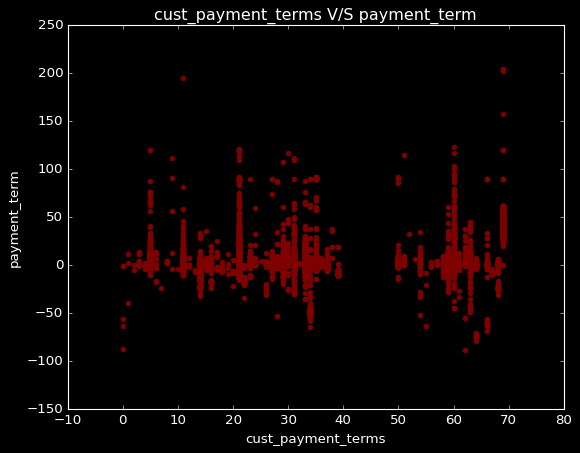

In [91]:
x_val = ['cust_number','business_code', 'total_open_amount', 'cust_payment_terms']
y_val = 'payment_term'
for col in x_val:
    plt.scatter(data[col],data['delay'],color=random.sample(['yellow','maroon'],1),linewidth = .5)
    plt.title('{} V/S {}'.format(col,y_val))
    plt.xlabel(col)
    plt.ylabel(y_val)
    plt.show()

In [92]:
data.nunique()

business_code                        6
cust_number                       1210
clear_date                         402
due_in_date                        491
total_open_amount                33206
baseline_create_date               423
cust_payment_terms                  59
payment_term                       144
due_term                            30
delay                              171
DELAY BUCKET(DAYS)                   6
DUE TERM BUCKET(DAYS)                5
delay_bucket_id                      6
due_term_bucket_id                   5
baseline_create_date.day            31
baseline_create_date.year            3
baseline_create_date.month          12
due_in_date.day                     31
due_in_date.year                     3
due_in_date.month                   12
Sum_base_amount                   1208
Sum_due_term                       279
mean_base_amount                  1205
mean_due_term                      229
amount/mean_amount               33268
amount-/mean_amount      

#### DISTRIBUTION PLOTS

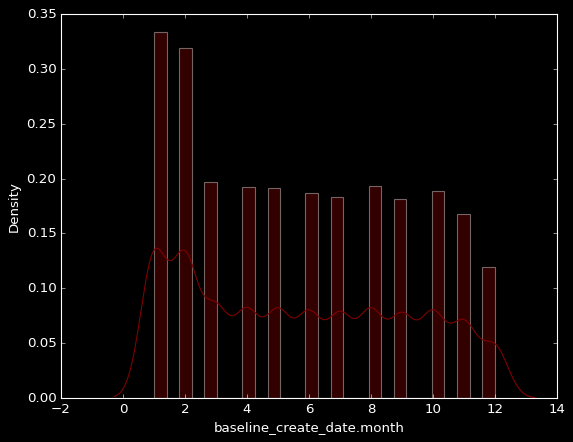

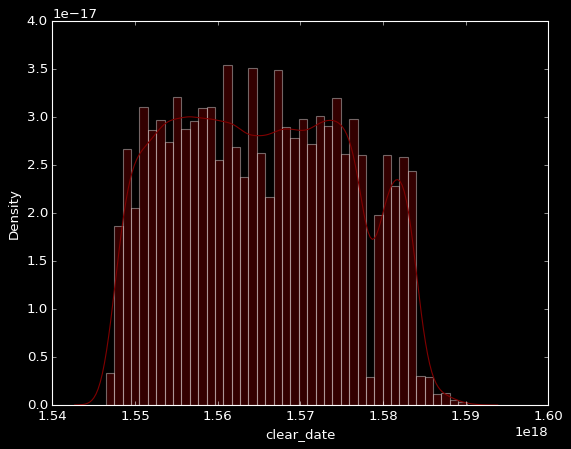

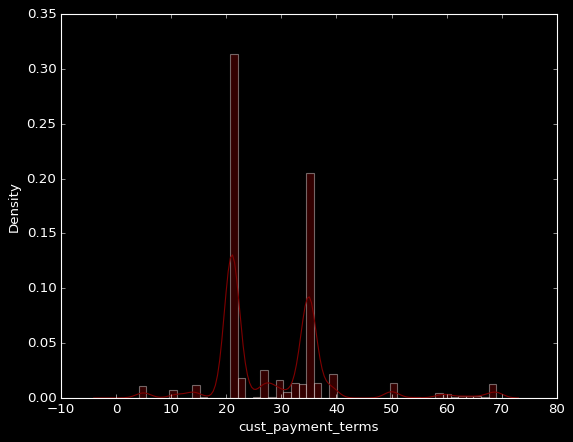

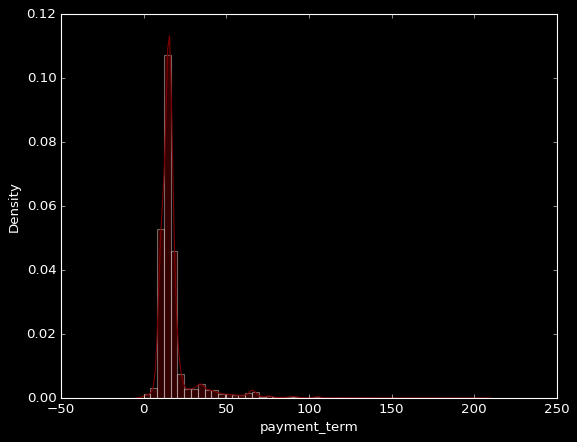

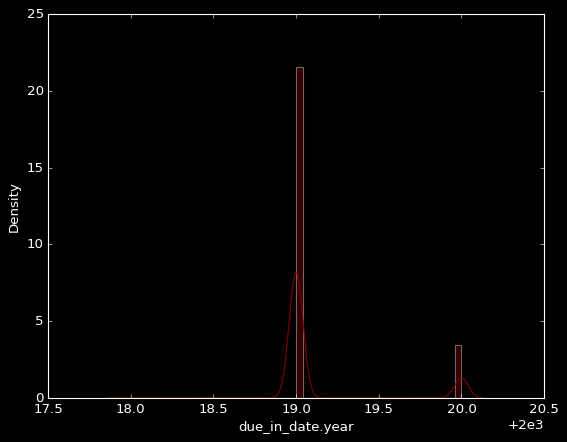

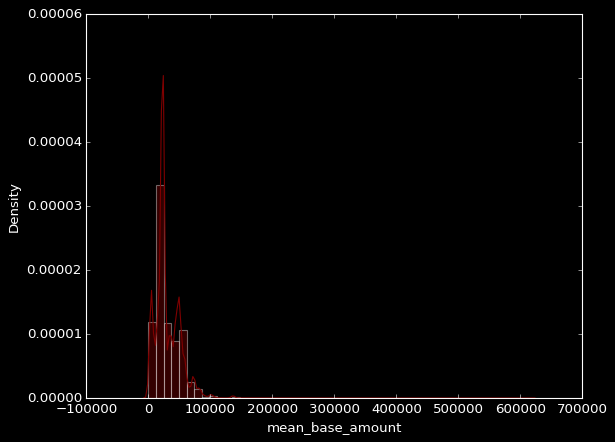

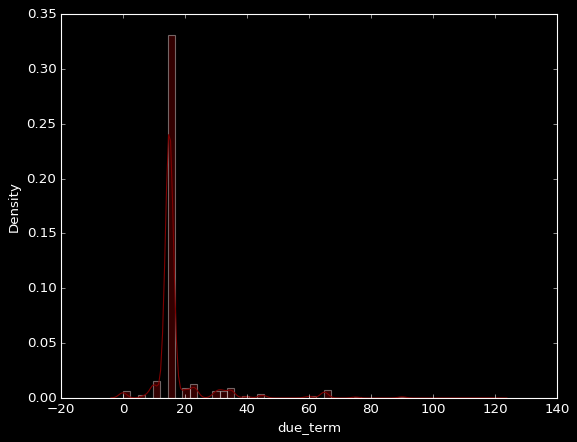

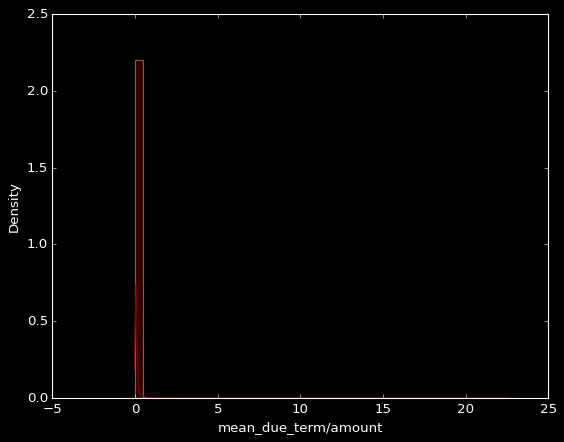

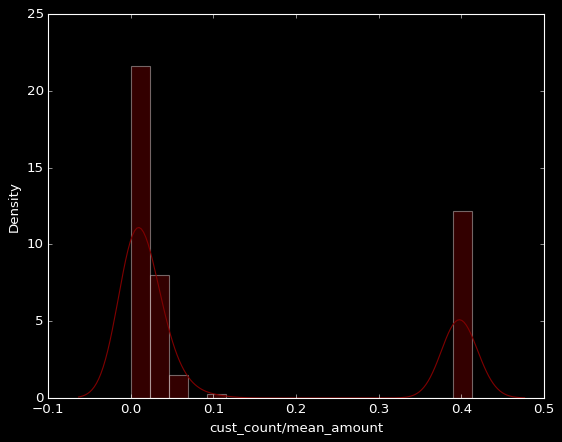

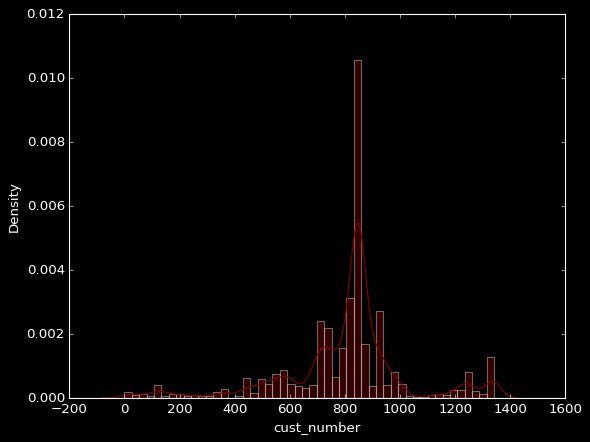

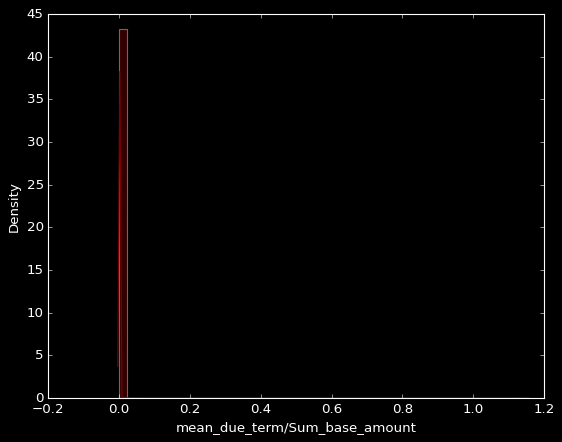

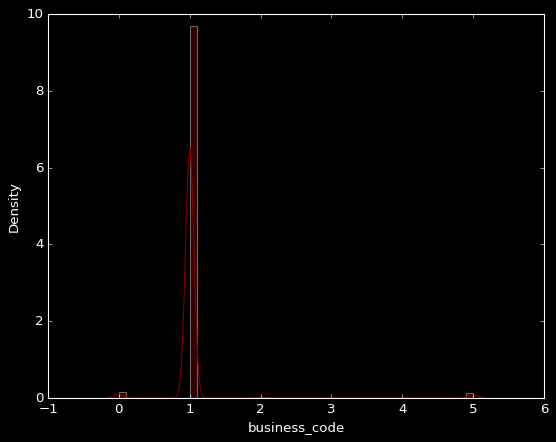

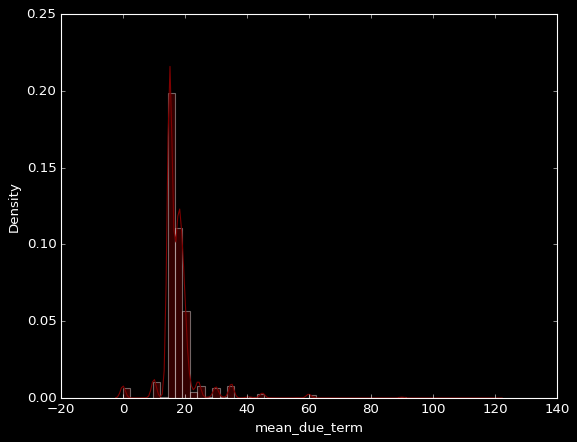

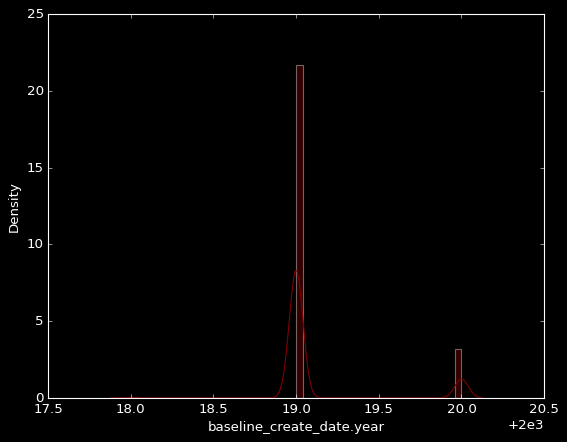

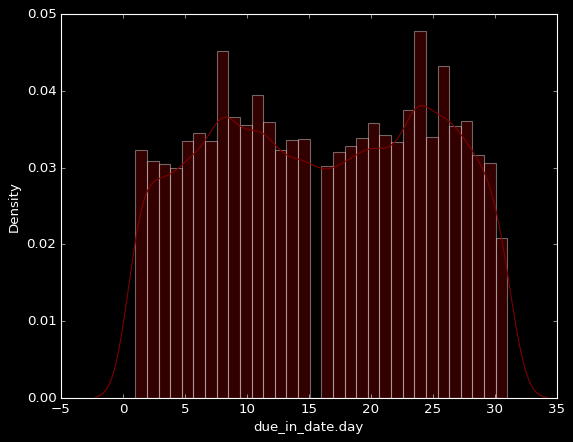

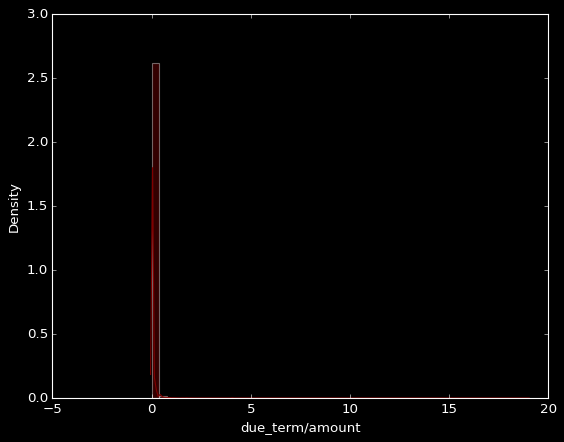

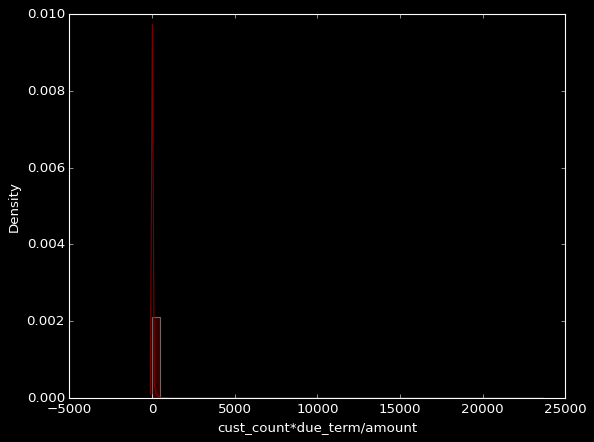

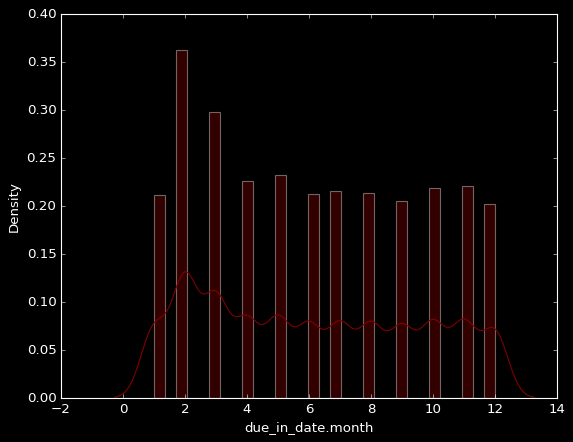

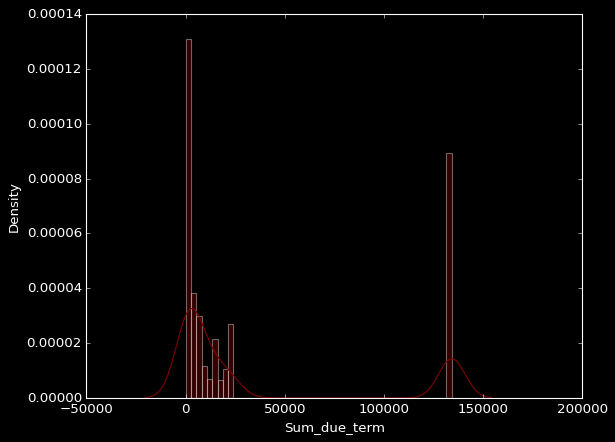

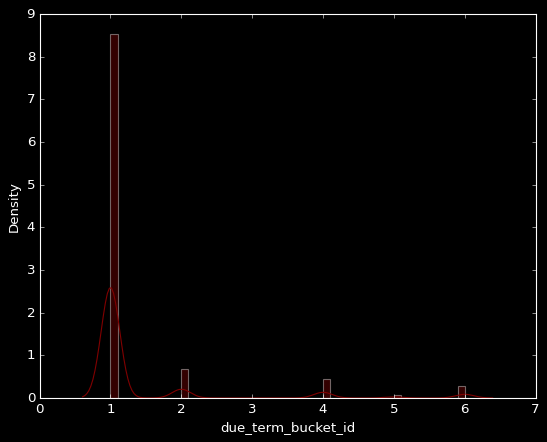

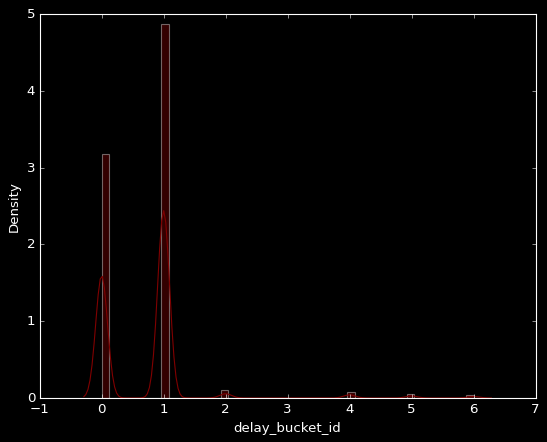

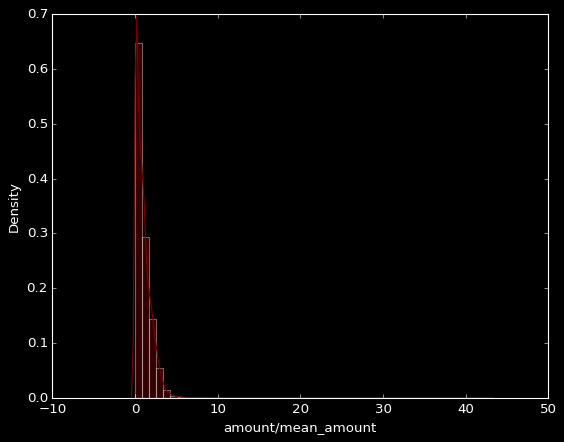

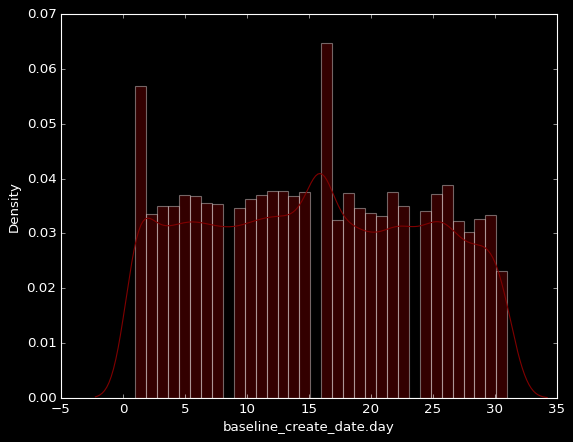

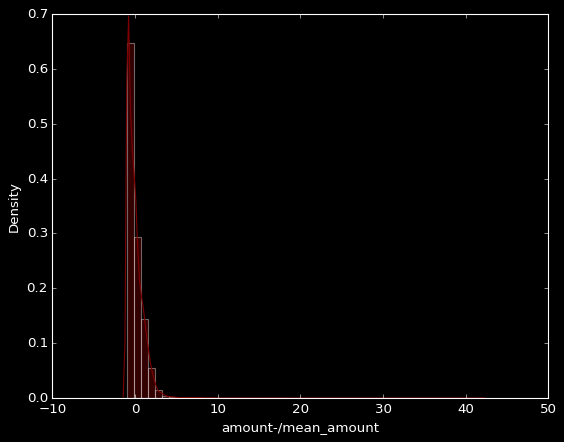

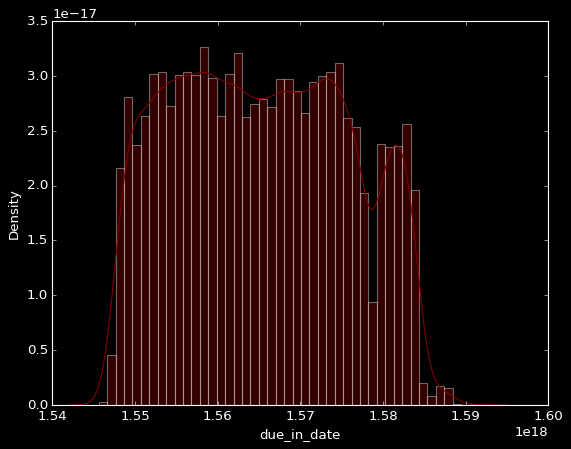

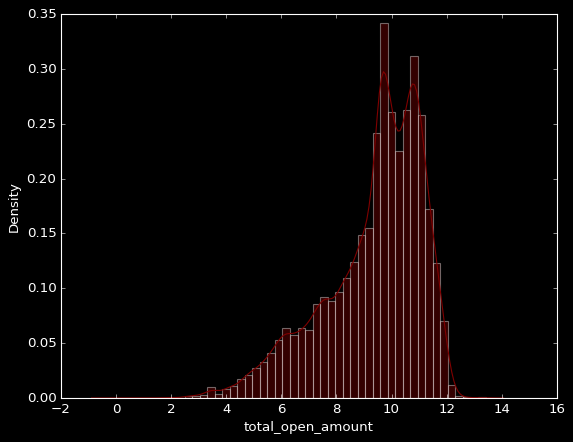

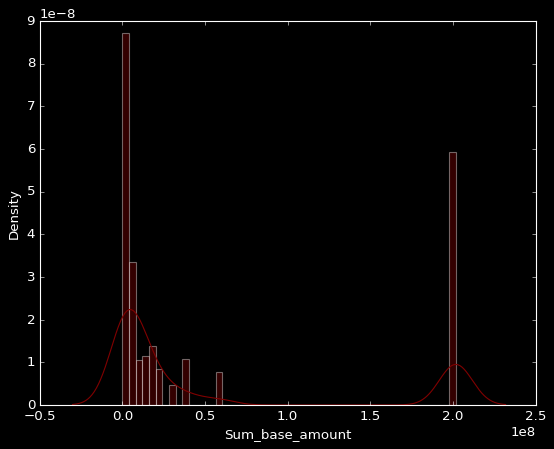

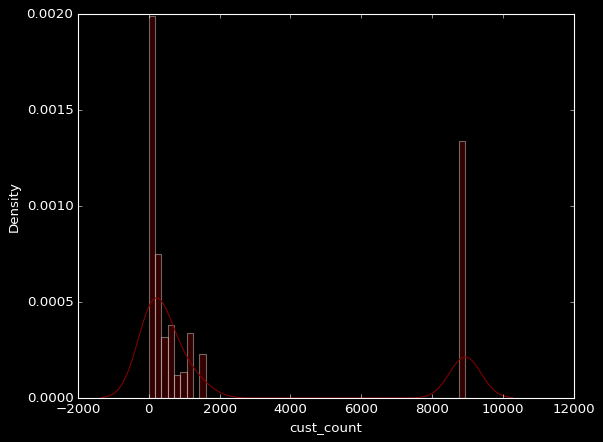

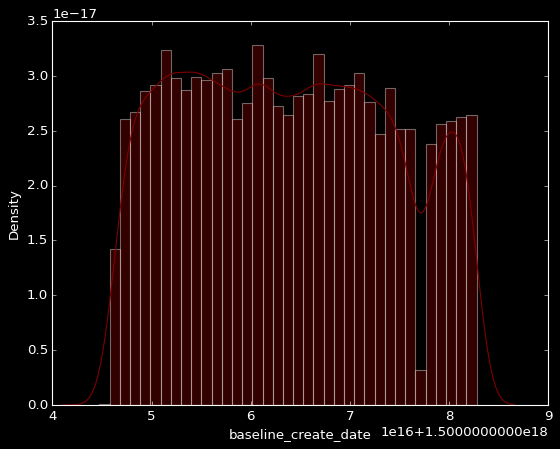

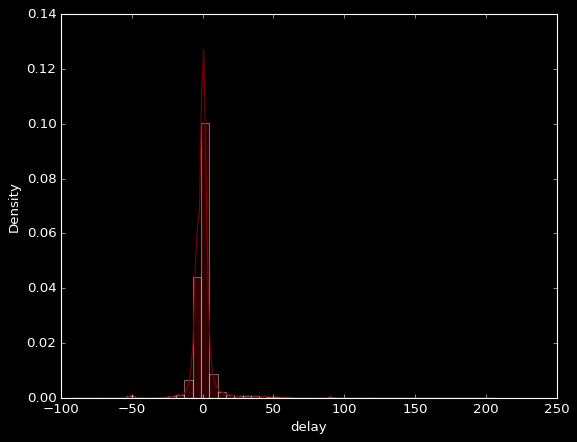

In [93]:
for col in list(set(data.columns) - set(['DELAY BUCKET(DAYS)' ,'DUE TERM BUCKET(DAYS)'])):
    seaborn.distplot(data[col],color='maroon')
    plt.show()

In [94]:
data_copy = data.copy()
test_dataset_copy = test_dataset.copy()

 ### OUTLIER DETECTION AND REMOVAL

clear_date-due_in_date(Payment term) > 100


15 > total_open_amount > 1 


-45 < delay <50


custumer_num  >50

In [95]:
data.describe()

,business_code,cust_number,total_open_amount,cust_payment_terms,payment_term,due_term,delay,delay_bucket_id,due_term_bucket_id,baseline_create_date.day,...,mean_base_amount,mean_due_term,amount/mean_amount,amount-/mean_amount,due_term/amount,mean_due_term/amount,mean_due_term/Sum_base_amount,cust_count,cust_count/mean_amount,cust_count*due_term/amount
count,37325.000000,37325.000000,37325.000000,37325.000000,37325.000000,37325.000000,37325.000000,37325.00000,37325.000000,37325.000000,...,37325.000000,37325.000000,37325.000000,3.732500e+04,37325.000000,37325.000000,3.732500e+04,37325.000000,37325.000000,37325.000000
mean,1.041688,805.012806,9.358676,28.644555,18.217629,17.704193,0.513436,0.70931,1.372833,15.415995,...,30585.966443,17.704193,1.000000,6.091726e-18,0.015455,0.013506,1.918242e-04,2431.373637,0.121881,30.793256
std,0.482608,229.900117,1.783860,11.046985,13.081307,10.607818,10.455137,0.78442,1.077304,8.802742,...,20809.697803,6.416354,1.201598,1.201598e+00,0.134528,0.135546,9.309912e-03,3665.325938,0.172904,280.114065
min,0.000000,0.000000,-0.235722,0.000000,0.000000,0.000000,-89.000000,0.00000,1.000000,1.000000,...,17.330000,0.000000,0.000018,-9.999824e-01,0.000000,0.000000,0.000000e+00,1.000000,0.000006,0.000000
25%,1.000000,719.000000,8.403825,21.000000,13.000000,15.000000,-3.000000,0.00000,1.000000,8.000000,...,21911.716847,15.021832,0.235093,-7.649068e-01,0.000329,0.000361,7.446699e-08,88.000000,0.002517,0.049140
50%,1.000000,849.000000,9.735389,23.000000,15.000000,15.000000,0.000000,1.00000,1.000000,16.000000,...,22584.495119,16.711934,0.715261,-2.847389e-01,0.000911,0.000973,1.679000e-06,388.000000,0.023724,0.483889
75%,1.000000,869.000000,10.713675,35.000000,17.000000,15.000000,2.000000,1.00000,1.000000,23.000000,...,43806.258014,18.571429,1.429739,4.297387e-01,0.003838,0.003807,9.121774e-06,1516.000000,0.395493,4.934987
max,5.000000,1342.000000,13.412931,69.000000,205.000000,120.000000,204.000000,6.00000,6.000000,31.000000,...,615881.557500,120.000000,42.839281,4.183928e+01,18.987342,22.615496,1.154068e+00,8932.000000,0.413199,23588.028169


In [96]:
pay_max = 80
data[data['payment_term']>=pay_max]['payment_term'].value_counts().sum()

315

In [97]:
data = data[(data['total_open_amount'] > 1) & (data['payment_term']<=pay_max )].reset_index(drop=True)

In [98]:
data.shape

(37013, 32)

In [99]:
test_dataset.shape

(10000, 29)

#### Distribution after removing outliers

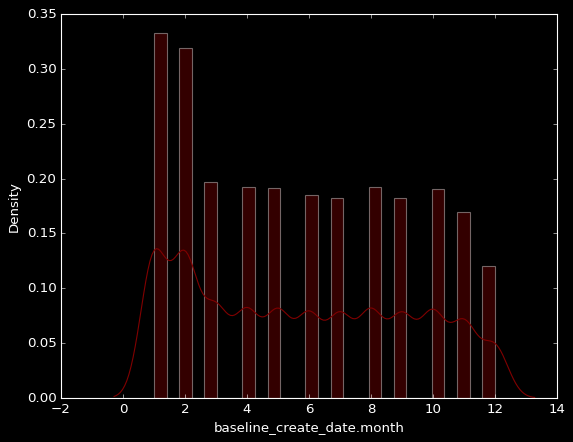

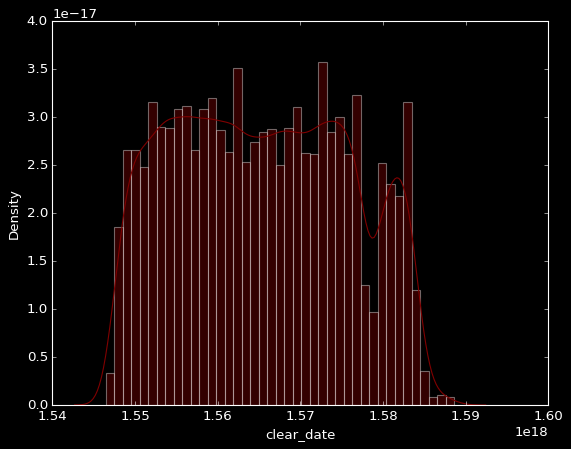

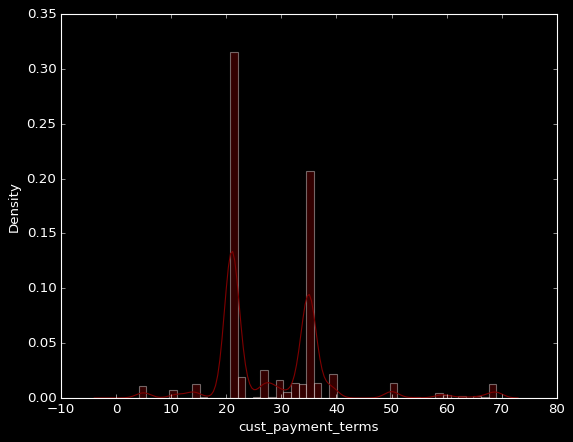

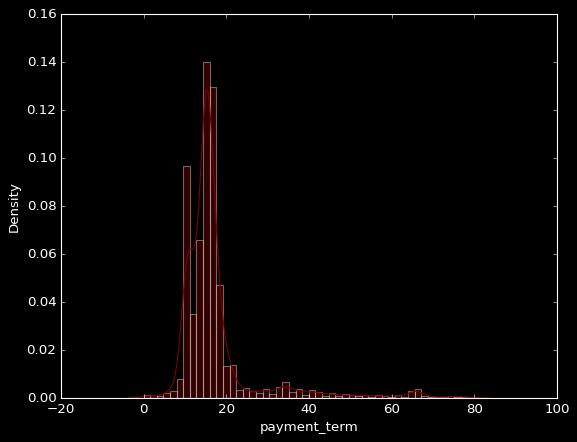

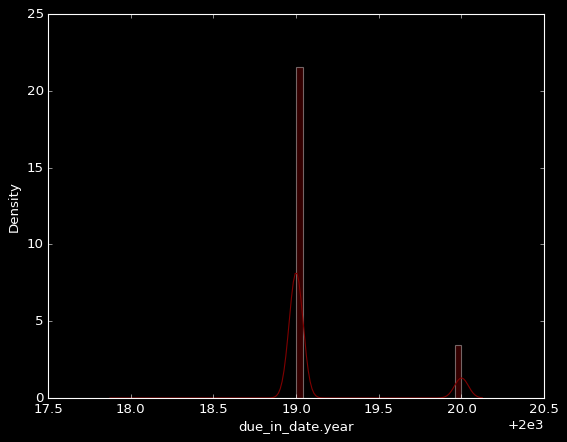

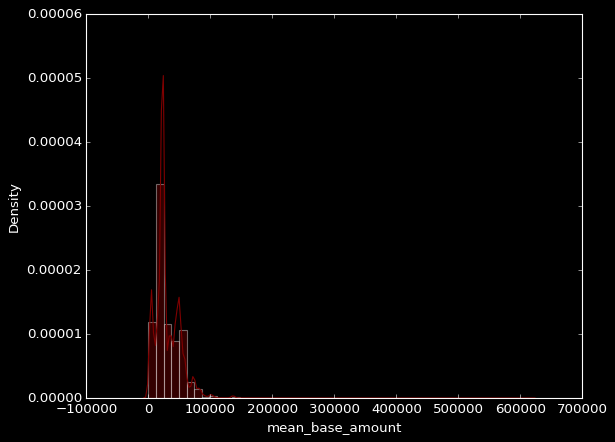

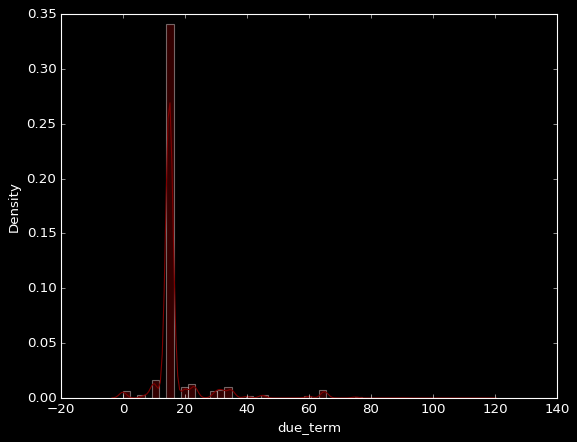

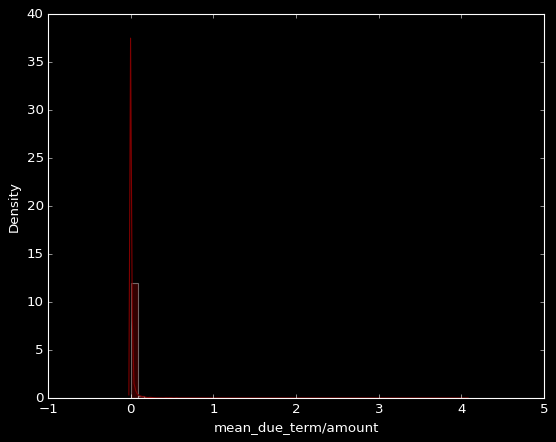

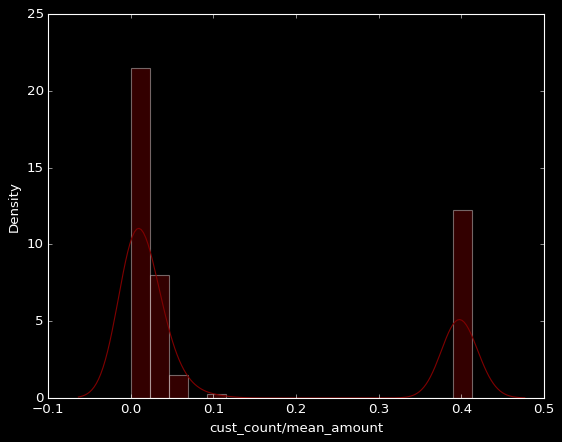

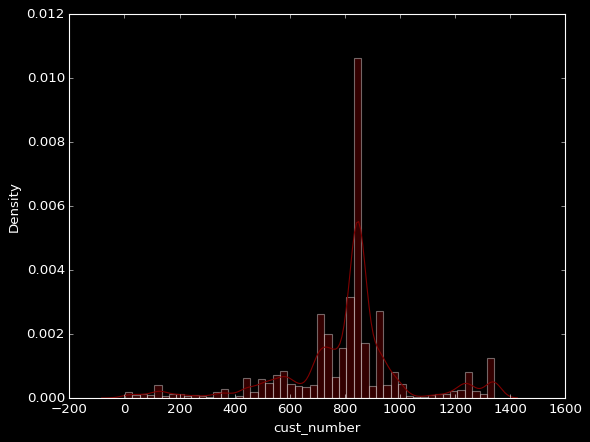

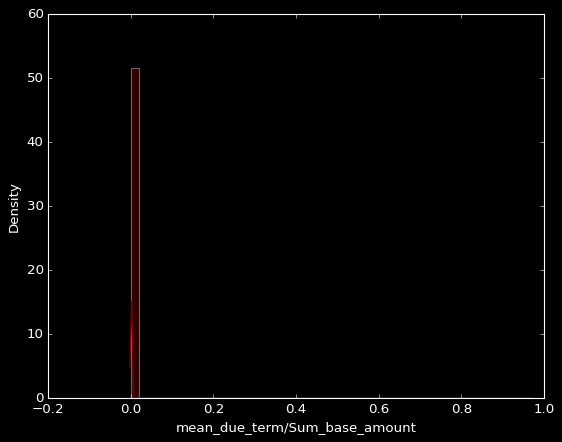

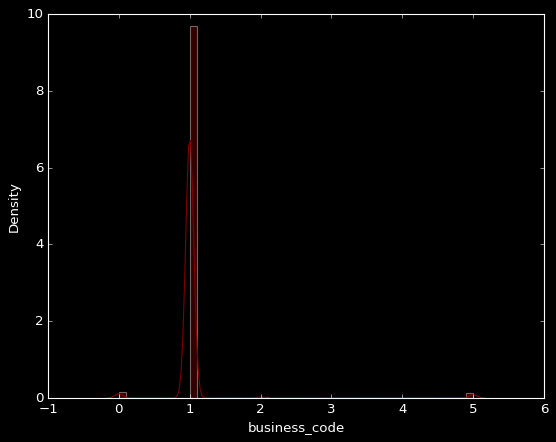

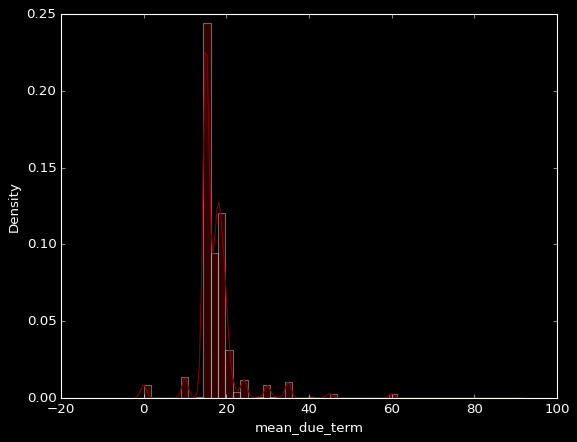

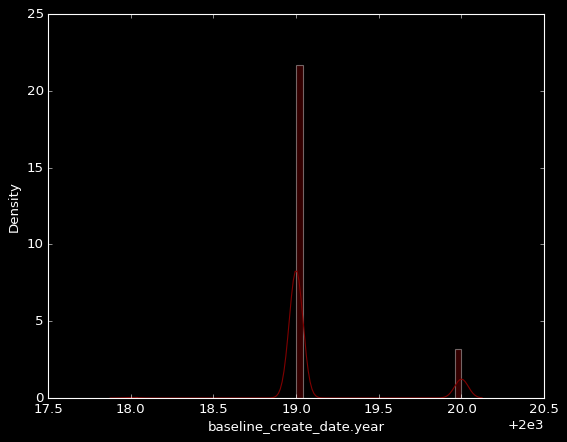

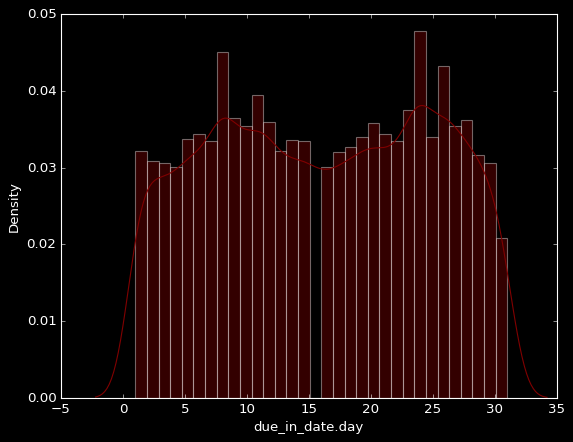

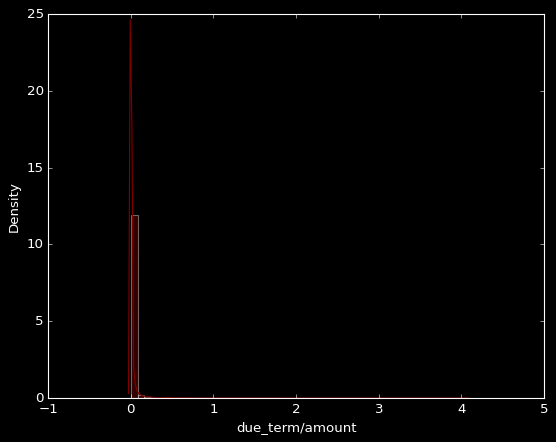

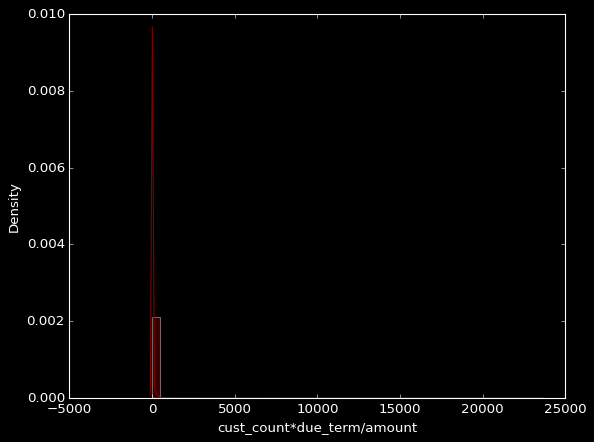

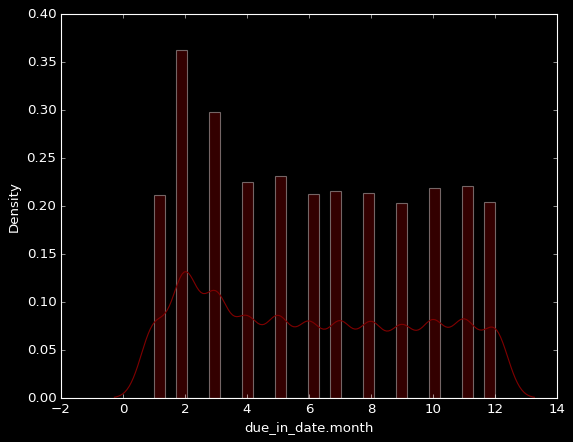

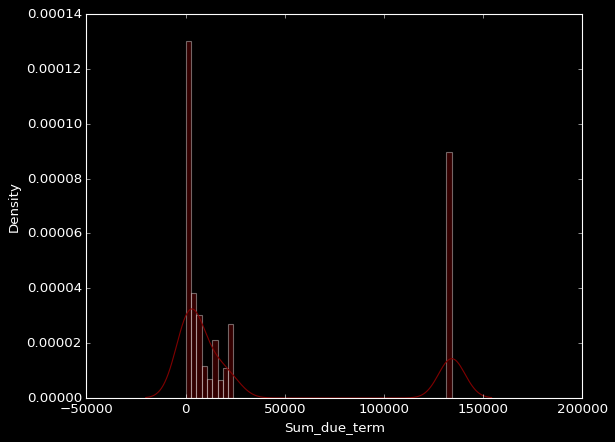

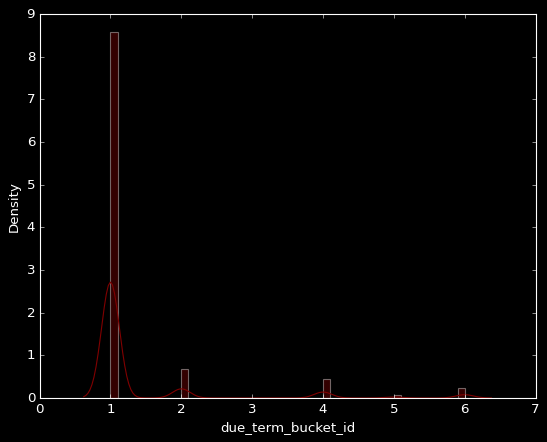

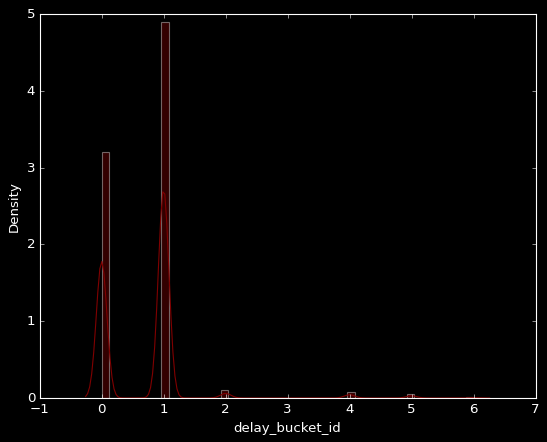

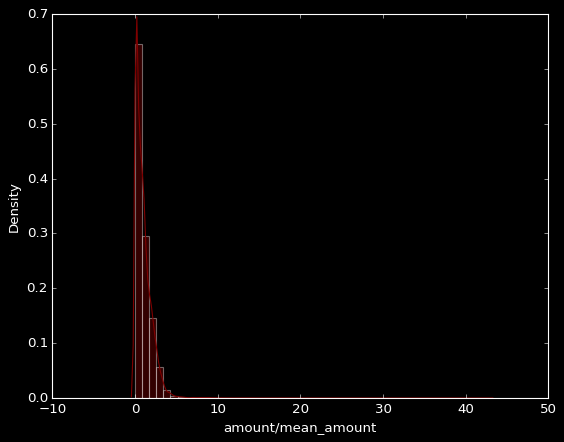

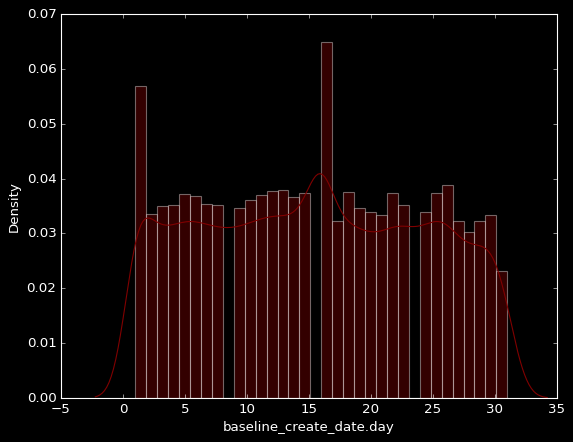

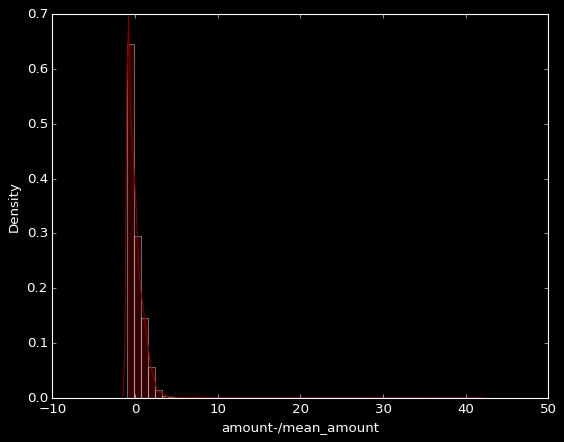

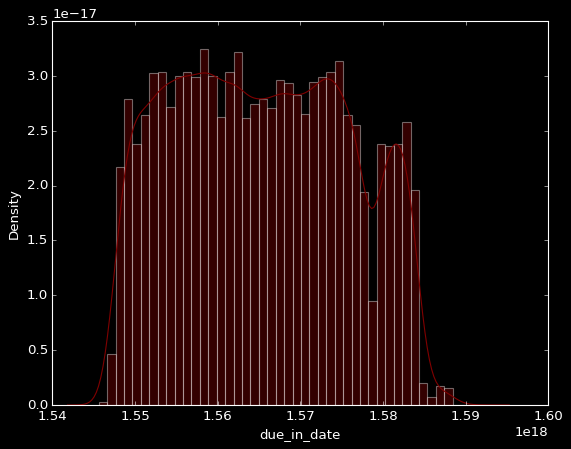

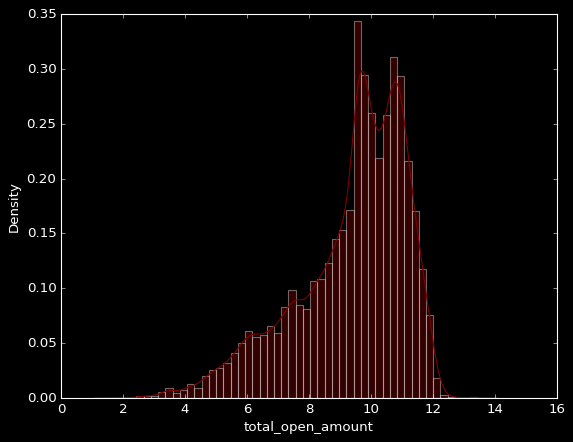

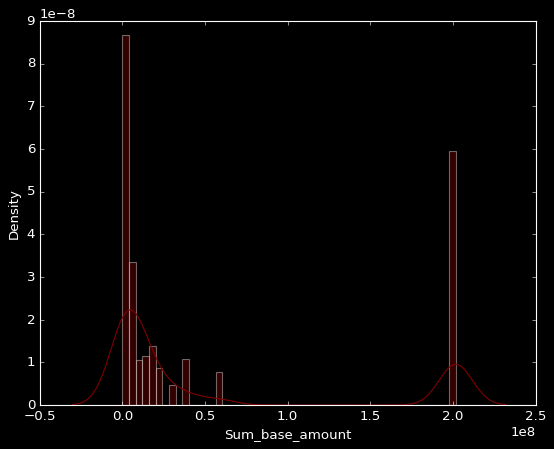

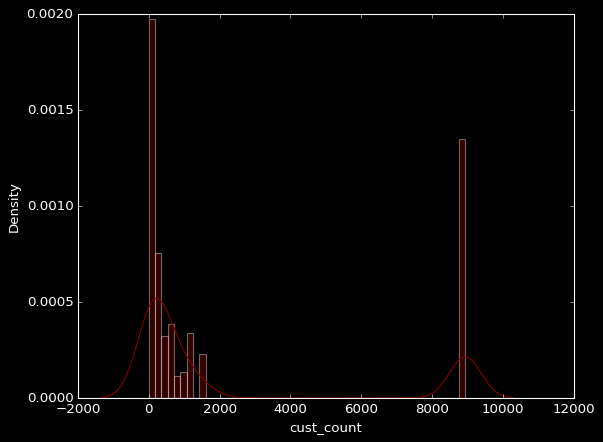

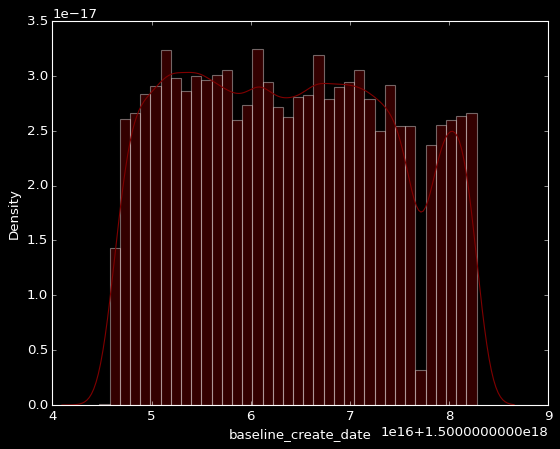

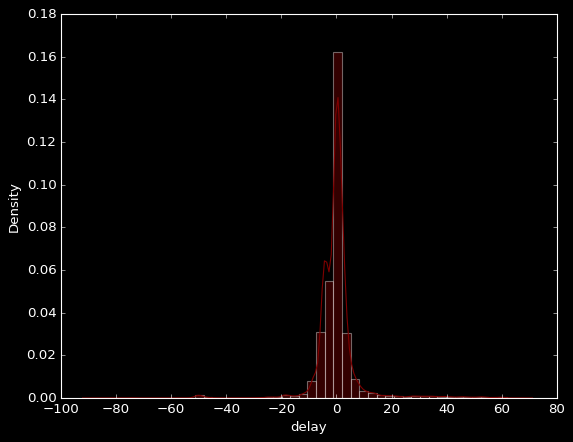

In [100]:
for col in list(set(data.columns) - set(['DELAY BUCKET(DAYS)' ,'DUE TERM BUCKET(DAYS)'])):
    seaborn.distplot(data[col],color='maroon')
    plt.show()

###  Diffrent Features

In [101]:
print(list(data.columns))
print("\n\n",len(list(data.columns)))

['business_code', 'cust_number', 'clear_date', 'due_in_date', 'total_open_amount', 'baseline_create_date', 'cust_payment_terms', 'payment_term', 'due_term', 'delay', 'DELAY BUCKET(DAYS)', 'DUE TERM BUCKET(DAYS)', 'delay_bucket_id', 'due_term_bucket_id', 'baseline_create_date.day', 'baseline_create_date.year', 'baseline_create_date.month', 'due_in_date.day', 'due_in_date.year', 'due_in_date.month', 'Sum_base_amount', 'Sum_due_term', 'mean_base_amount', 'mean_due_term', 'amount/mean_amount', 'amount-/mean_amount', 'due_term/amount', 'mean_due_term/amount', 'mean_due_term/Sum_base_amount', 'cust_count', 'cust_count/mean_amount', 'cust_count*due_term/amount']


 32


In [102]:
categorical_features = ['business_code', 'cust_payment_terms','due_term_bucket_id']

In [103]:
numerical_features = list(set(set(data.columns) - set(['DELAY BUCKET(DAYS)', 'DUE TERM BUCKET(DAYS)', 'delay_bucket_id', 'due_term_bucket_id','clear_date', 'due_in_date', 'baseline_create_date'])) - set(categorical_features))

In [104]:
len(numerical_features)

23

In [105]:
len(categorical_features)                                               

3

###  Scaling the Numerical features

In [106]:
infos_df = data[['clear_date', 'due_in_date', 'baseline_create_date','total_open_amount']]

In [107]:
train_num = data[list(set(numerical_features)   -  set(['payment_term','delay']))]
test_num = test_dataset[list(set(numerical_features)   -  set(['payment_term','delay']))]
train_cat = data[categorical_features]
test_cat = test_dataset[list(set(categorical_features))]

In [108]:
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
final_train_n = pd.DataFrame(scaler.fit_transform(train_num[list(set(numerical_features)-set(['payment_term','delay']))]),columns=list(set(numerical_features)-set(['payment_term','delay'])))
final_test_n = pd.DataFrame(scaler.fit_transform(test_num),columns=list(set(numerical_features)-set(['payment_term','delay'])))
data['delay'] = y_scaler.fit_transform(np.array(data['delay']).reshape(data['delay'].shape[0],1))

In [109]:
num_cols = final_train_n.columns

In [110]:
final_train_n=pd.merge(final_train_n,data['cust_number'],left_index=True,right_index=True)
final_test_n=pd.merge(final_test_n,test_dataset['cust_number'],left_index=True,right_index=True)

In [111]:
final_test_n=pd.merge(final_test_n,infos_df.drop(columns = ['clear_date']),left_index=True,right_index=True)

In [112]:
final_train_n=pd.merge(final_train_n,infos_df,left_index=True,right_index=True)

In [113]:
final_test_n.shape

(10000, 25)

In [114]:
final_train_n.shape

(37013, 26)

#### One-Hot Encoding the Categorical Data

In [115]:
data_cat=pd.concat((train_cat,test_cat),sort=False).reset_index(drop=True)
data_cat

,business_code,cust_payment_terms,due_term_bucket_id
0,0,5,1
1,1,21,1
2,1,35,1
3,1,35,1
4,1,35,1
...,...,...,...
47008,1,70,1
47009,1,35,1
47010,1,21,1
47011,0,8,1


In [116]:
data_cat1 = pd.get_dummies(data_cat,prefix='enc_c_',columns = ['business_code'],drop_first=False)
data_cat2 = pd.get_dummies(data_cat,prefix='enc_c___',columns = ['cust_payment_terms'],drop_first=False)
data_cat1 = pd.merge(data_cat1,data_cat2,left_index=True,right_index=True)
data_cat2 = pd.get_dummies(data_cat,prefix='enc_c',columns = ['due_term_bucket_id'],drop_first=False)
data_cat1 = pd.merge(data_cat1,data_cat2,left_index=True,right_index=True)

data_cat1 = data_cat1.drop(columns =['cust_payment_terms_x', 'due_term_bucket_id_x','due_term_bucket_id_y','business_code_y','cust_payment_terms_y','business_code_x'])    

In [117]:
data[['business_code','cust_payment_terms','due_term_bucket_id']].nunique().sum()

68

In [118]:
data_cat1.columns

Index(['enc_c__0', 'enc_c__1', 'enc_c__2', 'enc_c__3', 'enc_c__4', 'enc_c__5',
       'enc_c____0', 'enc_c____1', 'enc_c____2', 'enc_c____3', 'enc_c____4',
       'enc_c____5', 'enc_c____6', 'enc_c____7', 'enc_c____8', 'enc_c____9',
       'enc_c____10', 'enc_c____11', 'enc_c____12', 'enc_c____13',
       'enc_c____14', 'enc_c____15', 'enc_c____16', 'enc_c____17',
       'enc_c____18', 'enc_c____19', 'enc_c____20', 'enc_c____21',
       'enc_c____22', 'enc_c____23', 'enc_c____24', 'enc_c____25',
       'enc_c____26', 'enc_c____27', 'enc_c____28', 'enc_c____29',
       'enc_c____30', 'enc_c____31', 'enc_c____32', 'enc_c____33',
       'enc_c____34', 'enc_c____35', 'enc_c____36', 'enc_c____37',
       'enc_c____38', 'enc_c____39', 'enc_c____50', 'enc_c____51',
       'enc_c____52', 'enc_c____54', 'enc_c____55', 'enc_c____56',
       'enc_c____57', 'enc_c____58', 'enc_c____59', 'enc_c____60',
       'enc_c____62', 'enc_c____63', 'enc_c____64', 'enc_c____66',
       'enc_c____67', 'enc_c__

In [119]:
final_train_c = data_cat1[:data.shape[0]].reset_index(drop=True)
final_test_c = data_cat1[data.shape[0]:].reset_index(drop=True)

In [120]:
#final_train_c = train_cat
#final_test_c = test_cat

In [121]:
final_train_c.shape

(37013, 69)

In [122]:
final_test_c.shape

(10000, 69)

### Merging the Numerical, Categorical and Numerical-Categorical Data

In [123]:
test_data = final_test_n.merge(final_test_c.reset_index(drop=True),left_index=True,right_index=True)
#test_data = test_data.merge(final_test_c.reset_index(drop=True),left_index=True,right_index=True)
test_data

,baseline_create_date.month,due_in_date.month,due_in_date.year,Sum_due_term,mean_base_amount,due_term,mean_due_term/amount,cust_count/mean_amount,cust_number_x,mean_due_term/Sum_base_amount,...,enc_c____66,enc_c____67,enc_c____68,enc_c____69,enc_c____70,enc_c_1,enc_c_2,enc_c_4,enc_c_5,enc_c_6
0,0.0,0.2,0.0,0.001564,0.132595,0.135135,0.000009,0.001556,0.628081,0.000500,...,0,0,0,0,0,1,0,0,0,0
1,0.0,0.2,0.0,0.000782,0.060600,0.135135,0.000016,0.003933,0.722181,0.002186,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0.2,0.0,0.038186,0.143734,0.135135,0.000612,0.001486,0.650485,0.000022,...,0,0,0,0,0,1,0,0,0,0
3,0.0,0.0,0.0,0.000000,0.039417,0.000000,0.000000,0.008364,0.999253,0.000000,...,0,0,0,1,0,1,0,0,0,0
4,0.0,0.2,0.0,1.000000,0.052887,0.135135,0.000086,0.003939,0.631068,0.000002,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.6,0.0,0.000000,0.010677,0.000000,0.000000,0.013452,0.438387,0.000000,...,0,0,0,0,1,1,0,0,0,0
9996,1.0,0.8,0.0,0.149094,0.072573,0.135135,0.000034,0.002790,0.613891,0.000014,...,0,0,0,0,0,1,0,0,0,0
9997,1.0,0.8,0.0,0.010556,0.043973,0.135135,0.000525,0.005449,0.725915,0.000223,...,0,0,0,0,0,1,0,0,0,0
9998,1.0,0.6,0.0,0.000000,0.024228,0.000000,0.000000,0.000985,0.070948,0.000000,...,0,0,0,0,0,1,0,0,0,0


In [124]:
train_data = final_train_n.merge(final_train_c.reset_index(drop=True),left_index=True,right_index=True)
train_data = train_data.merge(data['delay'].reset_index(drop=True),left_index=True,right_index=True)
train_data

,baseline_create_date.month,due_in_date.month,due_in_date.year,Sum_due_term,mean_base_amount,due_term,mean_due_term/amount,cust_count/mean_amount,cust_number_x,mean_due_term/Sum_base_amount,...,enc_c____67,enc_c____68,enc_c____69,enc_c____70,enc_c_1,enc_c_2,enc_c_4,enc_c_5,enc_c_6,delay
0,1.000000,1.000000,0.0,0.000075,0.251651,0.085470,0.000016,0.000000,0.269202,6.661909e-05,...,0,0,0,0,1,0,0,0,0,0.757962
1,1.000000,1.000000,0.0,0.044084,0.041432,0.128205,0.007946,0.030110,0.525727,2.364394e-06,...,0,0,0,0,1,0,0,0,0,0.898089
2,1.000000,0.000000,0.5,1.000000,0.036622,0.128205,0.000108,0.957148,0.632364,7.689958e-08,...,0,0,0,0,1,0,0,0,0,0.535032
3,1.000000,0.000000,0.5,1.000000,0.036622,0.128205,0.000234,0.957148,0.632364,7.689958e-08,...,0,0,0,0,1,0,0,0,0,0.535032
4,1.000000,0.000000,0.5,1.000000,0.036622,0.128205,0.000179,0.957148,0.632364,7.689958e-08,...,0,0,0,0,1,0,0,0,0,0.535032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37008,0.090909,0.181818,1.0,1.000000,0.036622,0.128205,0.000635,0.957148,0.632364,7.689958e-08,...,0,0,0,0,1,0,0,0,0,0.547771
37009,0.090909,0.181818,1.0,0.009294,0.035100,0.128205,0.000494,0.009152,0.366890,8.847003e-06,...,0,0,0,0,1,0,0,0,0,0.605096
37010,0.090909,0.181818,1.0,0.059922,0.026099,0.128205,0.000470,0.061149,0.437733,3.112344e-06,...,0,0,0,0,1,0,0,0,0,0.605096
37011,0.090909,0.181818,1.0,0.000224,0.039133,0.128205,0.000147,0.000185,0.578673,3.209548e-04,...,0,0,0,0,1,0,0,0,0,0.585987


In [125]:
set(train_data.columns) - set(test_data.columns)

{'clear_date', 'delay'}

### GENERATING THE TEST-TRAIN-EVALUATION DATA

In [126]:
train_data = train_data.copy()
data_copy = data.copy()

In [127]:
x_data = train_data[set(train_data.columns) - set(['delay'])]
x_data.shape

(37013, 95)

In [128]:
x_test = test_data[set(test_data.columns) - set(['delay'])]
x_test.shape

(10000, 94)

In [129]:
y_data = train_data['delay']
y_data.shape

(37013,)

In [130]:
eval_range = (math.ceil(data.shape[0]*(0.25)))+1
x_train,x_eval,y_train,y_eval = x_data[eval_range:].reset_index(drop=True),x_data[0:eval_range].reset_index(drop=True),y_data[eval_range:].reset_index(drop=True),y_data[0:eval_range].reset_index(drop=True)       

In [131]:
eval_range = (math.ceil(x_eval.shape[0]*(0.4)))+1
x_eval1,x_eval2,y_eval1,y_eval2 = x_eval[eval_range:].reset_index(drop=True),x_eval[0:eval_range].reset_index(drop=True),y_eval[eval_range:].reset_index(drop=True),y_eval[0:eval_range].reset_index(drop=True)

In [132]:
x_eval1.columns

Index(['baseline_create_date.month', 'clear_date', 'enc_c____32',
       'due_in_date.year', 'enc_c____15', 'enc_c____54',
       'mean_due_term/amount', 'enc_c____5', 'mean_due_term/Sum_base_amount',
       'enc_c____59', 'enc_c__1', 'enc_c__0', 'enc_c____3', 'enc_c____23',
       'enc_c____52', 'enc_c____8', 'enc_c____17', 'baseline_create_date.year',
       'enc_c____0', 'due_term/amount', 'enc_c____26', 'enc_c____38',
       'cust_count*due_term/amount', 'enc_c____20', 'enc_c_2', 'enc_c____11',
       'enc_c____13', 'enc_c____62', 'enc_c____28', 'enc_c____29',
       'enc_c____16', 'enc_c____18', 'baseline_create_date.day', 'enc_c____22',
       'enc_c____30', 'enc_c____57', 'due_in_date', 'enc_c____60', 'enc_c_6',
       'enc_c____67', 'enc_c__2', 'enc_c____36', 'baseline_create_date',
       'enc_c____9', 'cust_number_x', 'total_open_amount_x',
       'mean_base_amount', 'enc_c____37', 'enc_c____58', 'due_term',
       'enc_c____69', 'enc_c____70', 'cust_count/mean_amount', 'enc_

In [133]:
x_train_info = x_train[['clear_date','total_open_amount_y','cust_number_y','baseline_create_date','due_in_date']]
x_eval1_info = x_eval1[['clear_date','total_open_amount_y','cust_number_y','baseline_create_date','due_in_date']]
x_eval2_info = x_eval2[['clear_date','total_open_amount_y','cust_number_y','baseline_create_date','due_in_date']]
x_test_info = x_test[['total_open_amount_y','cust_number_y','baseline_create_date','due_in_date']]

x_train = x_train.drop(columns=['clear_date','baseline_create_date','due_in_date'])
x_eval1 = x_eval1.drop(columns=['clear_date','baseline_create_date','due_in_date'])
x_eval2 = x_eval2.drop(columns=['clear_date','baseline_create_date','due_in_date'])
x_test = x_test.drop(columns=['baseline_create_date','due_in_date'])

In [134]:
x_train.shape,y_train.shape

((27758, 92), (27758,))

In [135]:
x_eval1.shape,y_eval1.shape

((5552, 92), (5552,))

In [136]:
x_eval2.shape,y_eval2.shape

((3703, 92), (3703,))

In [137]:
x_test.shape

(10000, 92)

In [138]:
#y_scaler.inverse_transform(np.array(y_eval).reshape(y_eval.shape[0],1))

In [139]:
#To write the final created dataset to the working directory
x_train.to_csv('x_train.csv')
x_test.to_csv('x_test.csv')
y_train.to_csv('y_train.csv')

x_eval1.to_csv('x_eval1.csv')
x_eval2.to_csv('x_eval2.csv')
y_eval1.to_csv('y_eval1.csv')
y_eval2.to_csv('y_eval2.csv')

### FEATURE SELECTION

In [140]:
gc.collect()

11591

In [141]:
def select_features(x_train,y_train,x_test,x_eval1,x_eval2):
    fs = SelectKBest(score_func = f_regression,k=10)
    fs.fit(x_train,y_train)
    col_indices = fs.get_support(indices=True)
    x_features = x_train.columns[col_indices]
    x_train_fs = pd.DataFrame(fs.transform(x_train),columns=x_features)
    x_test_fs = pd.DataFrame(fs.transform(x_test),columns=x_features)
    x_eval1_fs = pd.DataFrame(fs.transform(x_eval1),columns=x_features)
    x_eval2_fs = pd.DataFrame(fs.transform(x_eval2),columns=x_features)
    return x_train_fs,x_test_fs,x_eval1_fs,x_eval2_fs,fs,x_features,col_indices

In [142]:
#x_train_fs,x_test_fs,x_eval1_fs,x_eval2_fs,fs,x_features,col_indices = select_features(x_train,y_train,x_test,x_eval1,x_eval2)

In [143]:
#for i in range(len(fs.scores_[col_indices])):
#    print("\n",x_features[i],"    ",fs.scores_[col_indices][i])

In [144]:
#selected_features = list(set(train_data.corr()['delay'][train_data.corr()['delay']>0.5].index) - set(['delay']) )
#selected_features

## MODEL TRAINING , PREDICTION AND EVALUATION

In [145]:
x_train.columns

Index(['baseline_create_date.month', 'enc_c____32', 'due_in_date.year',
       'enc_c____15', 'enc_c____54', 'mean_due_term/amount', 'enc_c____5',
       'mean_due_term/Sum_base_amount', 'enc_c____59', 'enc_c__1', 'enc_c__0',
       'enc_c____3', 'enc_c____23', 'enc_c____52', 'enc_c____8', 'enc_c____17',
       'baseline_create_date.year', 'enc_c____0', 'due_term/amount',
       'enc_c____26', 'enc_c____38', 'cust_count*due_term/amount',
       'enc_c____20', 'enc_c_2', 'enc_c____11', 'enc_c____13', 'enc_c____62',
       'enc_c____28', 'enc_c____29', 'enc_c____16', 'enc_c____18',
       'baseline_create_date.day', 'enc_c____22', 'enc_c____30', 'enc_c____57',
       'enc_c____60', 'enc_c_6', 'enc_c____67', 'enc_c__2', 'enc_c____36',
       'enc_c____9', 'cust_number_x', 'total_open_amount_x',
       'mean_base_amount', 'enc_c____37', 'enc_c____58', 'due_term',
       'enc_c____69', 'enc_c____70', 'cust_count/mean_amount', 'enc_c____63',
       'enc_c__5', 'enc_c__4', 'enc_c__3', 'enc_c_

In [146]:
def evaluate_metrics(x,y_true,y_pred,mod):
    mean_abs_error = mean_absolute_error(y_true,y_pred)
    mean_sq_error = mean_squared_error(y_true,y_pred)
    root_mean_sq_error = mean_squared_error(y_true,y_pred)**0.5
    r2_scr = r2_score(y_true,y_pred)
    median_abs_score = median_absolute_error(y_true,y_pred)
    explained_variance = explained_variance_score(y_true,y_pred)
    return mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance  

In [147]:
data.corr()['payment_term']

business_code                    0.233041
cust_number                      0.111808
total_open_amount               -0.021609
cust_payment_terms               0.261544
payment_term                     1.000000
due_term                         0.629510
delay                            0.501131
delay_bucket_id                  0.523050
due_term_bucket_id               0.692635
baseline_create_date.day         0.006804
baseline_create_date.year        0.006117
baseline_create_date.month      -0.043435
due_in_date.day                 -0.021655
due_in_date.year                -0.002799
due_in_date.month                0.026157
Sum_base_amount                 -0.280411
Sum_due_term                    -0.282945
mean_base_amount                 0.043193
mean_due_term                    0.390345
amount/mean_amount              -0.047007
amount-/mean_amount             -0.047007
due_term/amount                  0.034920
mean_due_term/amount            -0.008028
mean_due_term/Sum_base_amount    0

In [148]:
regression_algo = ['1. LINEAR REGRESSION','2. RIDGE REGRESSION','3. LASSO REGRESSION','4. RANDOM FOREST REGRESSION','5. SUPPORT VECTOR REGRESSION(RBF)','6. DECISION TREE REGRESSION','7. XBF REGRESSION'] 

metric_names = ["MEAN ABSOLUTE ERROR","SCORE","MEAN SQUARED ERROR","ROOT MEAN SQUARED ERROR","R2 SCORE","MEDIAN ABSOLUTE ERROR","EXPLAINED VARIANCE SCORE"]

reg_metrics = []

### 1. LINEAR REGRESSION

In [149]:
gc.collect()

0

In [150]:
model1 = LinearRegression()
parameters = {'fit_intercept':[True,False],'n_jobs':[1,2,3],'normalize':[True,False]}
grid = GridSearchCV(estimator = model1,param_grid= parameters,scoring = 'neg_mean_squared_error',verbose = 1)     
grid_results = grid.fit(x_train,y_train)
print('BEST SCORE:  ',grid_results.best_score_)
print('BEST PARAMS:  ',grid_results.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
BEST SCORE:   -0.0069836529968080666
BEST PARAMS:   {'fit_intercept': False, 'n_jobs': 1, 'normalize': True}


In [151]:
model1 = LinearRegression(fit_intercept = grid_results.best_params_['fit_intercept'],n_jobs = grid_results.best_params_['n_jobs'])
model1.fit(x_train,y_train)
y_pred1 = model1.predict(x_eval1)
y_pred1 = y_pred1.reshape(y_pred1.shape[0])
y_eval1 = np.array(y_eval1)
y_predicted = y_scaler.inverse_transform(y_pred1.reshape(y_pred1.shape[0],1)).reshape(y_pred1.shape[0])
y_true = y_scaler.inverse_transform(y_eval1.reshape(y_eval1.shape[0],1)).reshape(y_eval1.shape[0])
mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,model1)
scr = model1.score(x_eval1,y_eval1)
reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])

print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    

METRICS  :

Mean Absolute Error :   0.02365470480920661 
Score :    0.47086500882142446 
Mean Squared Error :   0.002021318803735337 
Root Mean Squared Error :   0.04495907921360642 
R2 Square :   0.47086500882142446 
Median Absolute Score :   0.01046484780105783 
Explained Variance Score :   0.47175685040641013


In [152]:
reg_metrics

[[0.02365470480920661,
  0.47086500882142446,
  0.002021318803735337,
  0.04495907921360642,
  0.47086500882142446,
  0.01046484780105783,
  0.47175685040641013]]

In [153]:
def plot_regression_line(x_test,y_test,y_pred):
    for col in x_test.columns:
        #plt.scatter(x_test[col],y_test,color='red')
        plt.plot(x_test[col],y_pred1,color='yellow',linewidth = 0.5)
        plt.xlim(-0.00000000000001,0.000000000000001)
        plt.xlabel(col)
        plt.ylabel('delay')
        plt.title('{} V/S {} Regression Line\n'.format(col,'delay'))
        plt.show()

In [154]:
#plot_regression_line(x_eval1,y_eval1,y_pred1)

### 2. REGULARIZATION AND EVALUATION : RIDGE REGRESSION

In [155]:
ridge = Ridge()
parameters = {'alpha':[x for x in [0.0005,0.0001,0.00021,0.0006,0.1,0.001,0.005,0.008,0.1,0.5,1,0.1,0.09,0.08,0.06,0.05,0.03,0.01,0.02,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]}  

ridge_reg = GridSearchCV(ridge,param_grid = parameters,verbose=1)
ridge_reg = ridge_reg.fit(x_train,y_train)

alpha = ridge_reg.best_params_['alpha']

print("\n\nBest Alpha:  ",ridge_reg.best_params_,"\nScore:  ",ridge_reg.best_score_)

ridge_mod = Ridge(alpha=alpha)
ridge_mod=ridge_mod.fit(x_train,y_train)
y_pred1 = ridge_mod.predict(x_eval1)
y_pred2 = ridge_mod.predict(x_eval2)


mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,ridge_mod)
scr = ridge_mod.score(x_eval1,y_eval1)
print("\n\n\nMETRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)



Fitting 5 folds for each of 28 candidates, totalling 140 fits


Best Alpha:   {'alpha': 1} 
Score:   0.4528354195766191



METRICS  :

Mean Absolute Error :   0.023731950130560835 
Score :    0.4742743485541784 
Mean Squared Error :   0.002008294976876358 
Root Mean Squared Error :   0.04481400424952403 
R2 Square :   0.4742743485541784 
Median Absolute Score :   0.010728069133627949 
Explained Variance Score :   0.474457775944495


In [156]:
reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])
reg_metrics

[[0.02365470480920661,
  0.47086500882142446,
  0.002021318803735337,
  0.04495907921360642,
  0.47086500882142446,
  0.01046484780105783,
  0.47175685040641013],
 [0.023731950130560835,
  0.4742743485541784,
  0.002008294976876358,
  0.04481400424952403,
  0.4742743485541784,
  0.010728069133627949,
  0.474457775944495]]

In [157]:
# hyper parameter tuninhg using the evaluation set

ridge_reg = GridSearchCV(ridge,param_grid = parameters,verbose=1)
ridge_reg = ridge_reg.fit(x_eval1,y_eval1)
alpha = ridge_reg.best_params_['alpha']

print("\n\nBest Alpha:  ",ridge_reg.best_params_,"\nScore:  ",ridge_reg.best_score_)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


Best Alpha:   {'alpha': 0.06} 
Score:   0.46138387591370467


In [158]:
# For 2nd Evaluation set

mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval2,y_eval2,y_pred2,ridge_mod)
scr = ridge_mod.score(x_eval2,y_eval2)
print("\n\n\nMETRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    




METRICS  :

Mean Absolute Error :   0.01983952711358618 
Score :    0.49295658661233144 
Mean Squared Error :   0.0014734839884281454 
Root Mean Squared Error :   0.038385986875787696 
R2 Square :   0.49295658661233144 
Median Absolute Score :   0.010561231050330577 
Explained Variance Score :   0.49381436775001164


### 3. REGULARIZATION AND EVALUATION : LASSO REGRESSION

In [159]:
# Hyper Parameter tuning using the train data

lasso_reg = Lasso()
parameters = {'alpha':[x for x in [0.0005,0.0001,0.00021,0.0006,0.1,0.001,0.005,0.008,0.1,0.5,1]]}  
lasso_reg = GridSearchCV(lasso_reg,param_grid=parameters,verbose=1)
lasso_reg.fit(x_train,y_train)

print("\n\n\nBest Alpha : ",lasso_reg.best_params_,"\nBest Score : ",lasso_reg.best_score_)

lasso_reg = Lasso(alpha=0.0001)
lasso_reg = lasso_reg.fit(x_train,y_train)
y_pred1 = np.array(lasso_reg.predict(x_eval1))

mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1.reshape(y_eval1.shape[0],1),y_pred1.reshape(y_pred1.shape[0],1),ridge_mod)
scr = lasso_reg.score(x_eval1,y_eval1)
reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])

print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    

Fitting 5 folds for each of 11 candidates, totalling 55 fits



Best Alpha :  {'alpha': 0.0001} 
Best Score :  0.5032923209620292
METRICS  :

Mean Absolute Error :   0.023860826606970625 
Score :    0.4568372477671575 
Mean Squared Error :   0.0020749054643531507 
Root Mean Squared Error :   0.0455511302203705 
R2 Square :   0.4568372477671575 
Median Absolute Score :   0.010184399823561896 
Explained Variance Score :   0.4572691790556348


In [160]:
# Hyper Parameter tuning using the 1st evaluation Data

parameters = {'alpha':[x for x in [0.0005,0.0002,0.0003,0.0004,0.009,0.0001,0.00021,0.0006,0.1,0.001,0.005,0.008,0.1,0.5,1]]}  
lasso_reg = GridSearchCV(lasso_reg,param_grid=parameters)
lasso_reg.fit(x_eval1,y_eval1)

print("\n\n\nBest Alpha : ",lasso_reg.best_params_,"\nBest Score : ",lasso_reg.best_score_)

lasso_reg = Lasso(alpha=0.0001)
lasso_reg = lasso_reg.fit(x_train,y_train)    




Best Alpha :  {'alpha': 0.0001} 
Best Score :  0.45039476848598203


In [161]:
## We still get the best value of alpha as : 0.0001.. So ther e is not much difference


# Evaluating on the 2nd Evaluation Data

y_pred2 = np.array(lasso_reg.predict(x_eval2))

mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval2,np.array(y_eval2).reshape(np.array(y_eval2).shape[0],1),y_pred2.reshape(y_pred2.shape[0],1),ridge_mod)
scr = lasso_reg.score(x_eval2,y_eval2)
#reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])

print("\n\n1st Evaluation Data\n\nMETRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    



1st Evaluation Data

METRICS  :

Mean Absolute Error :   0.01998569870461641 
Score :    0.49607766199422765 
Mean Squared Error :   0.0014644140459331326 
Root Mean Squared Error :   0.03826766318882213 
R2 Square :   0.49607766199422765 
Median Absolute Score :   0.010358418943441805 
Explained Variance Score :   0.497321463047808


 ### 4. RANDOM FOREST REGRESSOR

In [162]:
gc.collect()

120

In [163]:
%%time

# Performing Grid-Search
#gsc = GridSearchCV(estimator = RandomForestRegressor(),param_grid={'max_depth':[9,10],'n_estimators':(500,1000)},cv=5,scoring = 'neg_mean_squared_error',verbose=1,n_jobs=-1)
#grid_result = gsc.fit(x_train,y_train)
#best_params = grid_result.best_params_
#print("\n\nBest Params : \n",best_params)

rfr = RandomForestRegressor(max_depth=10,n_estimators=500,random_state=False,verbose=True) 

rfr.fit(x_train,y_train)

y_pred1 = rfr.predict(x_eval1)

scr = rfr.score(x_eval1,y_eval1)

mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,rfr)
reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])

print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


METRICS  :

Mean Absolute Error :   0.019781288372177113 
Score :    0.6083775448336338 
Mean Squared Error :   0.0014960149031717 
Root Mean Squared Error :   0.038678351867313325 
R2 Square :   0.6083775448336338 
Median Absolute Score :   0.008934037704097064 
Explained Variance Score :   0.6092292184053457
Wall time: 1min 54s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


In [164]:
# Evaluating in with the 2nd evaluation data

y_pred2 = rfr.predict(x_eval2)

scr = rfr.score(x_eval2,y_eval2)

mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval2,np.array(y_eval2).reshape(np.array(y_eval2).shape[0],1),y_pred2,rfr)
print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


METRICS  :

Mean Absolute Error :   0.017345272095437087 
Score :    0.5524533087425361 
Mean Squared Error :   0.0013005846565206675 
Root Mean Squared Error :   0.03606361957042953 
R2 Square :   0.5524533087425361 
Median Absolute Score :   0.007649842957616948 
Explained Variance Score :   0.5536640208202492


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


In [165]:
reg_metrics

[[0.02365470480920661,
  0.47086500882142446,
  0.002021318803735337,
  0.04495907921360642,
  0.47086500882142446,
  0.01046484780105783,
  0.47175685040641013],
 [0.023731950130560835,
  0.4742743485541784,
  0.002008294976876358,
  0.04481400424952403,
  0.4742743485541784,
  0.010728069133627949,
  0.474457775944495],
 [0.023860826606970625,
  0.4568372477671575,
  0.0020749054643531507,
  0.0455511302203705,
  0.4568372477671575,
  0.010184399823561896,
  0.4572691790556348],
 [0.019781288372177113,
  0.6083775448336338,
  0.0014960149031717,
  0.038678351867313325,
  0.6083775448336338,
  0.008934037704097064,
  0.6092292184053457]]

### 5. SUPPORT VECTOR MACHINES: REGRESSION

### Linear Kernel

In [166]:
# C: regulation parameter --> inversely proportional to regularization
# 'epsilon' --> It specifies the epsilon-tube within whic LPVh no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.

In [167]:
%%time

#gsc1 = GridSearchCV(estimator=SVR(kernel='linear'),param_grid={'C':[0.1,1,10,100,1000],'epsilon':[10,5,1,0.1,0.5,0.01,0.001,0.0001,0.00001]},cv=5,scoring='neg_mean_squared_error',verbose=0,n_jobs=-1)      
#grid_result = gsc1.fit(x_train,y_train)
#best_params = grid_result.best_params_
#svr1 = SVR(kernel='linear',C=10,epsilon=0.01,cache_size=200,verbose=True,max_iter = -1)        
#svr1 = svr1.fit(x_train,y_train)
#y_pred1 = svr1.fit(x_eval1,y_eval1)
#mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,svr1)
#scr = svr1.score(x_eval1,y_eval1)
#reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])
#print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)   

Wall time: 0 ns


### 5.2. Using 'polynomial' kernel[](http://)

In [168]:
%%time

#gsc1 = GridSearchCV(estimator=SVR(kernel='poly'),param_grid={'C':[0.1,1,10,100,1000],'epsilon':[10,5,1,0.1,0.5,0.01,0.01,0.005,0.001,0.0001,0.00001],'degree':[2,3,4,5],'coef0':[0.1,0.01,0.001,0.0001]},cv=5,scoring='neg_mean_squared_error',verbose=0,n_jobs=-1)      
#grid_result = gsc1.fit(x_train,y_train)
#best_params = grid_result.best_params_
#svr1 = SVR(kernel='poly',C=1,epsilon=0.01,coef0=0.001,degree = 2,shrinking = True, tol=0.001 ,cache_size=200,verbose=False,max_iter = -1)        
#y_pred1 = svr1.predict(x_eval1,y_eval1)
#mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,svr1)
#scr = svr1.score(x_eval1,y_eval1)
#reg_metrics.append([mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])

#print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)   

Wall time: 0 ns


### 5.3. Using 'RBF' kernel

In [169]:
%%time

#gsc1 = GridSearchCV(estimator=SVR(kernel='rbf'),param_grid={'C':[0.1,1,10,100,1000],'epsilon':[10,5,1,0.1,0.5,0.01,0.01,0.005,0.001,0.0001,0.0005],'gamma':[5,3,1,0.1,0.01,0.05,0.001,0.005,0.0001]},cv=5,scoring='neg_mean_squared_error',verbose=0,n_jobs=-1)      
#grid_result = gsc1.fit(x_train,y_train)
#best_params = grid_result.best_params_
#svr1 = SVR(kernel='rbf',C=10,epsilon=0.01,gamma=0.01,coef0=0.1,shrinking = True, tol=0.001 ,cache_size=200,verbose=True,max_iter = -1)        
#svr1 = svr1.fit(x_train,y_train)
#y_pred1 = svr1.predict(x_eval1)
#mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,svr1)
#scr = svr1.score(x_eval1,y_eval1)
#reg_metrics.append([mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])
#print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)   

Wall time: 0 ns


### 6. DECISION TREE REGRESSOR

In [170]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train,y_train)
y_pred1 = dtr.predict(x_eval1)
mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,dtr)
scr = dtr.score(x_eval1,y_eval1)
reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])
print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)   

METRICS  :

Mean Absolute Error :   0.024589176563446467 
Score :    0.20208205331947993 
Mean Squared Error :   0.003048081446798351 
Root Mean Squared Error :   0.05520943258899109 
R2 Square :   0.20208205331947993 
Median Absolute Score :   0.01273885350318471 
Explained Variance Score :   0.2024776182639778


### 7. XGB REGRESSOR

In [171]:
cols = list(set(x_train.columns) - set(['cust_payment_terms', 'business_code']) )

In [172]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(x_train,y_train)
y_pred1 = xgb_model.predict(x_eval1)
mean_abs_error,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance = evaluate_metrics(x_eval1,y_eval1,y_pred1,dtr)
scr = dtr.score(x_eval1,y_eval1)
reg_metrics.append([mean_abs_error,scr,mean_sq_error,root_mean_sq_error,r2_scr,median_abs_score,explained_variance])
print("METRICS  :\n\nMean Absolute Error :  ",mean_abs_error,"\nScore :   ",scr,"\nMean Squared Error :  ",mean_sq_error,"\nRoot Mean Squared Error :  ",root_mean_sq_error,"\nR2 Square :  ",r2_scr,"\nMedian Absolute Score :  ",median_abs_score,"\nExplained Variance Score :  ",explained_variance)   

METRICS  :

Mean Absolute Error :   0.01964881586341678 
Score :    0.20208205331947993 
Mean Squared Error :   0.0015612230849500392 
Root Mean Squared Error :   0.039512315611085605 
R2 Square :   0.5913075355771571 
Median Absolute Score :   0.00948953704469524 
Explained Variance Score :   0.5923044130903624


### Comparision between METRICS

In [173]:
regression_algo = ['1. LINEAR REGRESSION','2. RIDGE REGRESSION','3. LASSO REGRESSION','4. RANDOM FOREST REGRESSION','5. DECISION TREE REGRESSION','6. XBF REGRESSION'] 

metric_names = ["MEAN ABSOLUTE ERROR","SCORE","MEAN SQUARED ERROR","ROOT MEAN SQUARED ERROR","R2 SCORE","MEDIAN ABSOLUTE ERROR","EXPLAINED VARIANCE SCORE"]


In [174]:
comp_metrics = pd.DataFrame(reg_metrics,columns= metric_names, index = regression_algo)

In [175]:
comp_metrics

,MEAN ABSOLUTE ERROR,SCORE,MEAN SQUARED ERROR,ROOT MEAN SQUARED ERROR,R2 SCORE,MEDIAN ABSOLUTE ERROR,EXPLAINED VARIANCE SCORE
1. LINEAR REGRESSION,0.023655,0.470865,0.002021,0.044959,0.470865,0.010465,0.471757
2. RIDGE REGRESSION,0.023732,0.474274,0.002008,0.044814,0.474274,0.010728,0.474458
3. LASSO REGRESSION,0.023861,0.456837,0.002075,0.045551,0.456837,0.010184,0.457269
4. RANDOM FOREST REGRESSION,0.019781,0.608378,0.001496,0.038678,0.608378,0.008934,0.609229
5. DECISION TREE REGRESSION,0.024589,0.202082,0.003048,0.055209,0.202082,0.012739,0.202478
6. XBF REGRESSION,0.019649,0.202082,0.001561,0.039512,0.591308,0.009490,0.592304


In [176]:
x_test_info

,total_open_amount_y,cust_number_y,baseline_create_date,due_in_date
0,11.479804,845,2018-12-14,2018-12-24
1,6.357634,971,2018-12-14,2018-12-29
2,10.440950,875,2018-12-30,2019-01-14
3,9.668121,1342,2018-12-30,2019-01-14
4,9.937666,849,2018-12-30,2019-01-14
...,...,...,...,...
9995,10.227497,591,2019-04-18,2019-05-03
9996,9.650612,826,2019-04-18,2019-05-23
9997,7.409730,976,2019-04-18,2019-05-03
9998,10.025804,99,2019-04-18,2019-05-03


 ### COMPUTATION OF OUR ESTIMATED PAYMENT DATE ( We are using the '' model --- Better Accuracy as compared to other)

In [181]:
output = pd.DataFrame(columns=['INVOICE CREATE DATE','AMOUNT(IN USD)','INVOICE DUE DATE','INVOICE PAYMENT TERM','INVOICE PAYMENT DATE','DELAY','BUCKET ID'])

In [182]:
output['INVOICE CREATE DATE'] = x_test_info['baseline_create_date']
output['INVOICE DUE DATE'] = x_test_info['due_in_date']
output['AMOUNT(IN USD)'] = x_test_info['total_open_amount_y'].apply(np.exp)

In [183]:
x_test = x_test.dropna()
y_pred = model1.predict(x_test)
y_pred = y_scaler.inverse_transform(np.array(y_pred).reshape(np.array(y_pred).shape[0],1)).reshape(np.array(y_pred).shape[0])
y_pred = np.ceil(np.array(y_pred))

In [184]:
output['INVOICE PAYMENT TERM'] = y_pred
output['INVOICE PAYMENT DATE'] = output['INVOICE CREATE DATE'] + pd.to_timedelta(np.ceil(output['INVOICE PAYMENT TERM']),'D')

ValueError: Length of values (9773) does not match length of index (10000)

In [ ]:
output['INVOICE PAYMENT TERM'] 

In [ ]:
output['DELAY'] = pd.Series(output['INVOICE PAYMENT TERM'] - output['INVOICE DUE DATE']).dt.days

In [ ]:
num_cols

In [ ]:
x_test_num = x_test[(set(num_cols) - set(['cust_number']))|set(['cust_number_x'])]

In [ ]:
x_test_num.shape

In [ ]:
x_test_num = pd.Series(scaler.inverse_transform(np.array(x_test_num)))

In [ ]:
output['INVOICE CREATE DATE'] = pd.Datetime(x_test['metric_names'])